# Imports and Helper functions

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import itertools
import json
import pickle
import seaborn as sns

# Disable warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Set the style for the plots
sns.set_palette("pastel")

def load_and_preprocess_data(data_dir, valid_samples=100):
    """Loads the dataset, preprocesses it, and splits it into train, validation, and test sets."""
    images_folder = os.path.join(data_dir, "images")
    styles_path = os.path.join(data_dir, "styles.csv")

    df = pd.read_csv(styles_path, on_bad_lines="skip")
    df = df[df["id"].apply(lambda x: os.path.isfile(os.path.join(images_folder, str(x) + ".jpg")))]
    df["image"] = df["id"].apply(lambda x: os.path.join(images_folder, str(x) + ".jpg"))
    df = df[["image", "articleType"]]

    # Filter categories with at least valid_samples samples
    valid_categories = df["articleType"].value_counts()[df["articleType"].value_counts() >= valid_samples].index
    df = df[df["articleType"].isin(valid_categories)]

    # Split data into train, validation, and test sets
    train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["articleType"], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["articleType"], random_state=42)
    
    # Calculate total number of images
    total_images = len(df)

    # Print the number of samples in each set
    print(f"Total number of images after filtering: {total_images}")
    print(f"Number of samples in train set: {len(train_df)}")
    print(f"Number of samples in validation set: {len(val_df)}")
    print(f"Number of samples in test set: {len(test_df)}")
    
    return train_df, val_df, test_df, total_images

def resize_with_padding(image, target_height, target_width):
    """Resizes the image to the target size with padding."""
    height, width = tf.shape(image)[0], tf.shape(image)[1]

    if tf.equal(height, 0) or tf.equal(width, 0):
        return tf.zeros([target_height, target_width, 3], dtype=tf.float32)

    scale = tf.minimum(
        tf.cast(target_width, tf.float32) / tf.cast(width, tf.float32),
        tf.cast(target_height, tf.float32) / tf.cast(height, tf.float32),
    )
    new_height = tf.cast(tf.cast(height, tf.float32) * scale, tf.int32)
    new_width = tf.cast(tf.cast(width, tf.float32) * scale, tf.int32)
    resized_image = tf.image.resize(image, [new_height, new_width])
    padded_image = tf.image.pad_to_bounding_box(
        resized_image,
        (target_height - new_height) // 2,
        (target_width - new_width) // 2,
        target_height,
        target_width,
    )
    return padded_image

def preprocess_image(image_path, target_size, preprocess_input_func):
    """Loads, resizes, and preprocesses a single image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = resize_with_padding(image, target_size[0], target_size[1])
    image = preprocess_input_func(image)
    return image

def create_dataset(df, batch_size, target_size, preprocess_input_func, is_training=False):
    """Creates a TensorFlow dataset from the dataframe."""
    image_paths = df["image"].values
    labels = pd.get_dummies(df["articleType"]).values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    if is_training:
        dataset = dataset.shuffle(buffer_size=len(df))

    dataset = dataset.map(
        lambda image_path, label: (preprocess_image(image_path, target_size, preprocess_input_func), label),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

def build_model(model_name, input_shape, num_classes):
    """Builds and compiles the CNN model."""
    if model_name == "ResNet50":
        base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "Xception":
        base_model = tf.keras.applications.Xception(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "EfficientNetV2M":
        base_model = tf.keras.applications.EfficientNetV2M(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "InceptionV3":
        base_model = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Make the last 20 layers trainable
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2048, activation="relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])
    return model

def train_model(model, model_name, train_dataset, val_dataset, epochs=30):
    """Trains the model and returns the training history."""
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"models/best_model_{model_name}.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode="max",
        verbose=1
    )
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.4, patience=3, min_lr=1e-6),
        model_checkpoint
    ]

    history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=1, callbacks=callbacks)
    return history

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(30, 25))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    plt.tight_layout()
    

def plot_macro_average_prc_curve(true_labels, predicted_probs, class_labels, model_name):
    plt.figure(figsize=(10, 8))
    
    # Binarize the labels
    true_labels_bin = label_binarize(true_labels, classes=range(len(class_labels)))
    
    # Compute Precision-Recall curve and average precision for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(class_labels)):
        precision[i], recall[i], _ = precision_recall_curve(true_labels_bin[:, i], predicted_probs[:, i])
        average_precision[i] = average_precision_score(true_labels_bin[:, i], predicted_probs[:, i])
    
    # Compute macro-average precision-recall curve
    precision["macro"], recall["macro"], _ = precision_recall_curve(true_labels_bin.ravel(), predicted_probs.ravel())
    average_precision["macro"] = average_precision_score(true_labels_bin, predicted_probs, average="macro")
    
    # Plot macro-average precision-recall curve
    plt.plot(recall["macro"], precision["macro"], 
             label=f'Macro-average PRC (AP = {average_precision["macro"]:.2f})',
             color='navy', linestyle='-', linewidth=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Macro-Average Precision-Recall Curve for {model_name}')
    plt.legend(loc="lower left")
    plt.savefig(f'artifacts/macro_avg_prc_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    return average_precision["macro"]

# Model Configuration

Total number of images after filtering: 42150
Number of samples in train set: 33720
Number of samples in validation set: 4215
Number of samples in test set: 4215


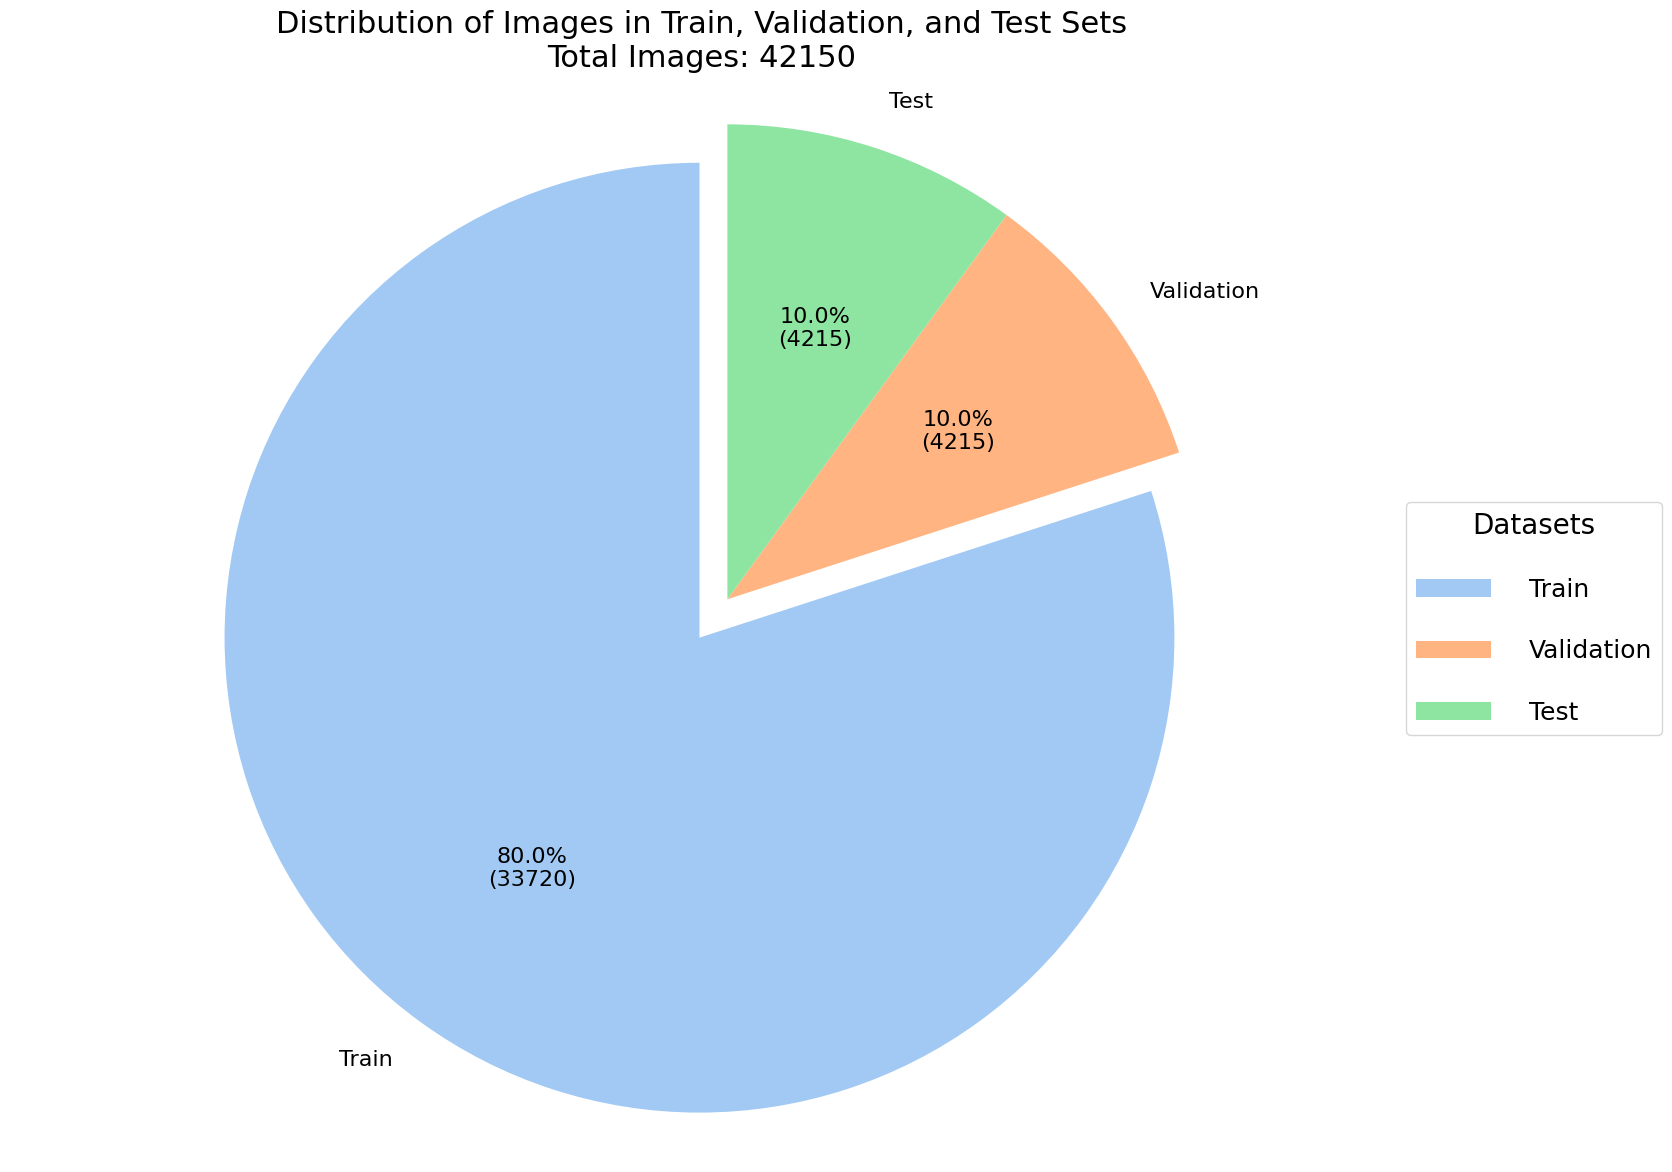

Pie chart has been saved as 'data_split_distribution.png'

Displaying resized images for ResNet50:


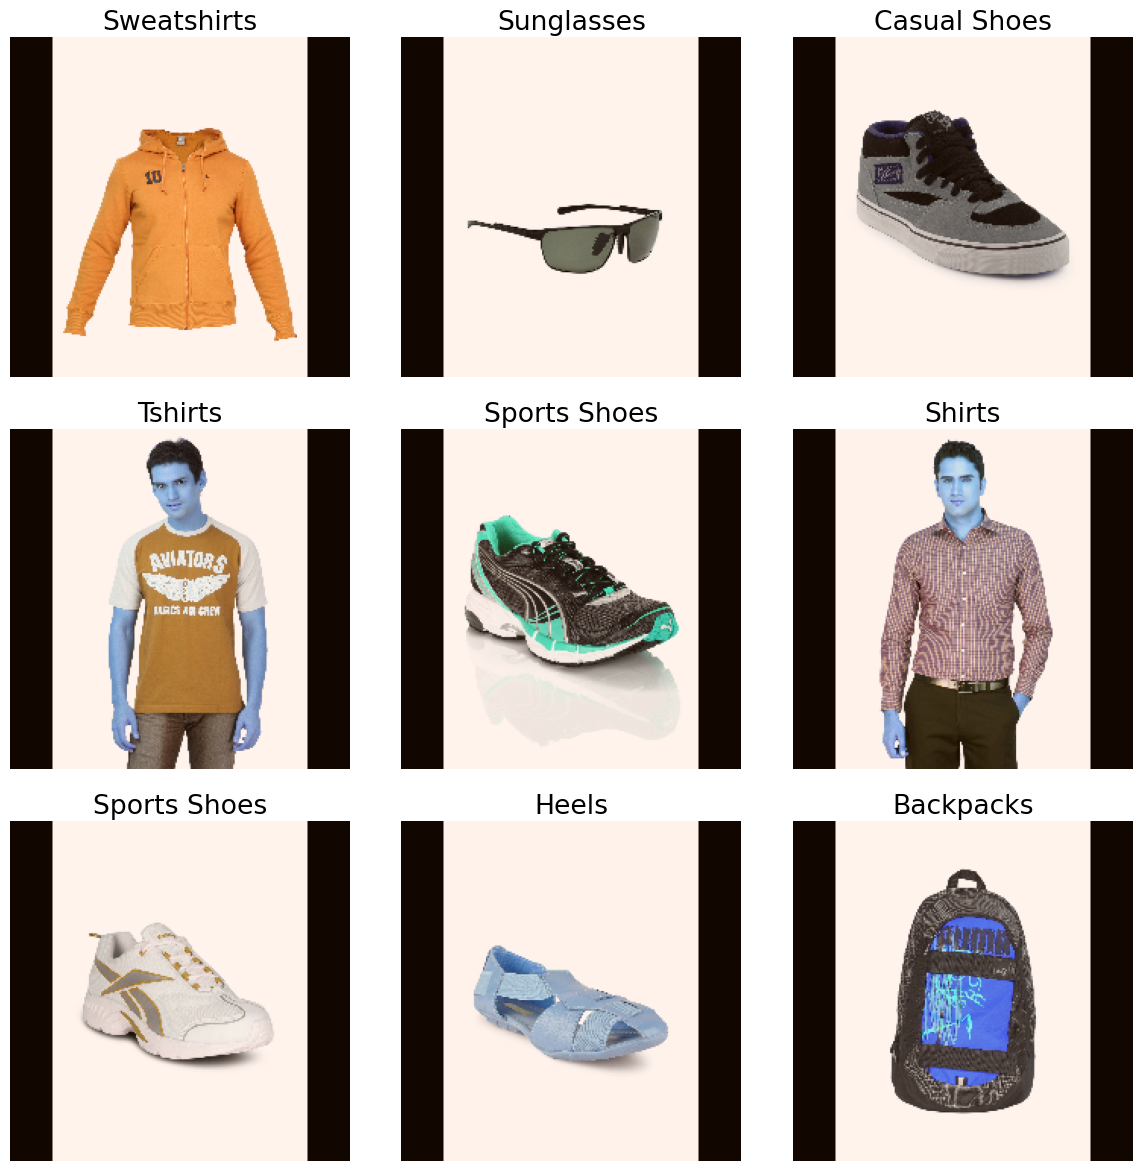


Displaying resized images for Xception:


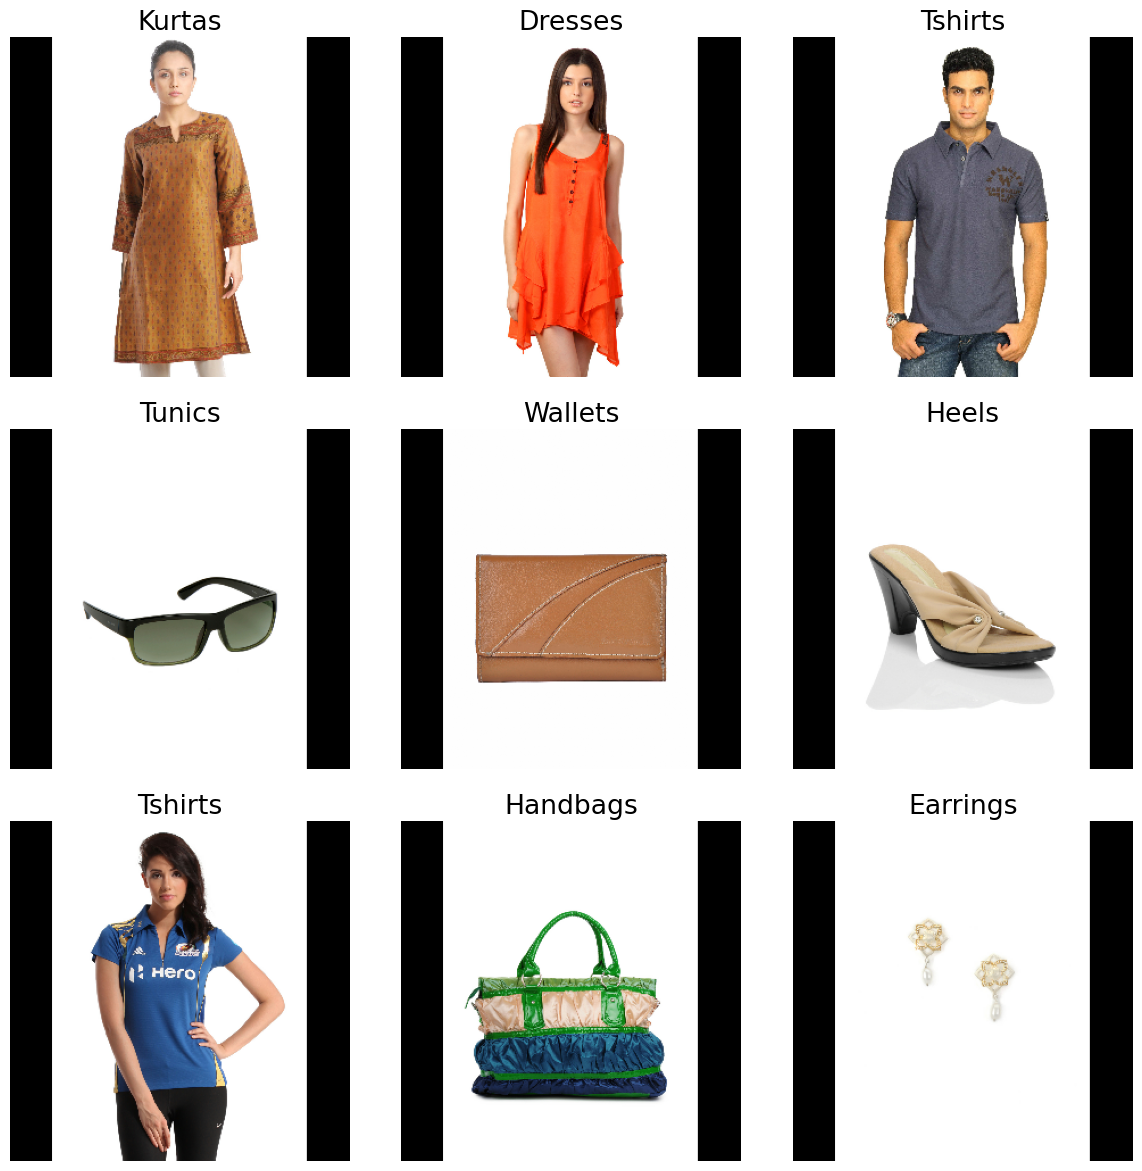


Displaying resized images for EfficientNetV2M:


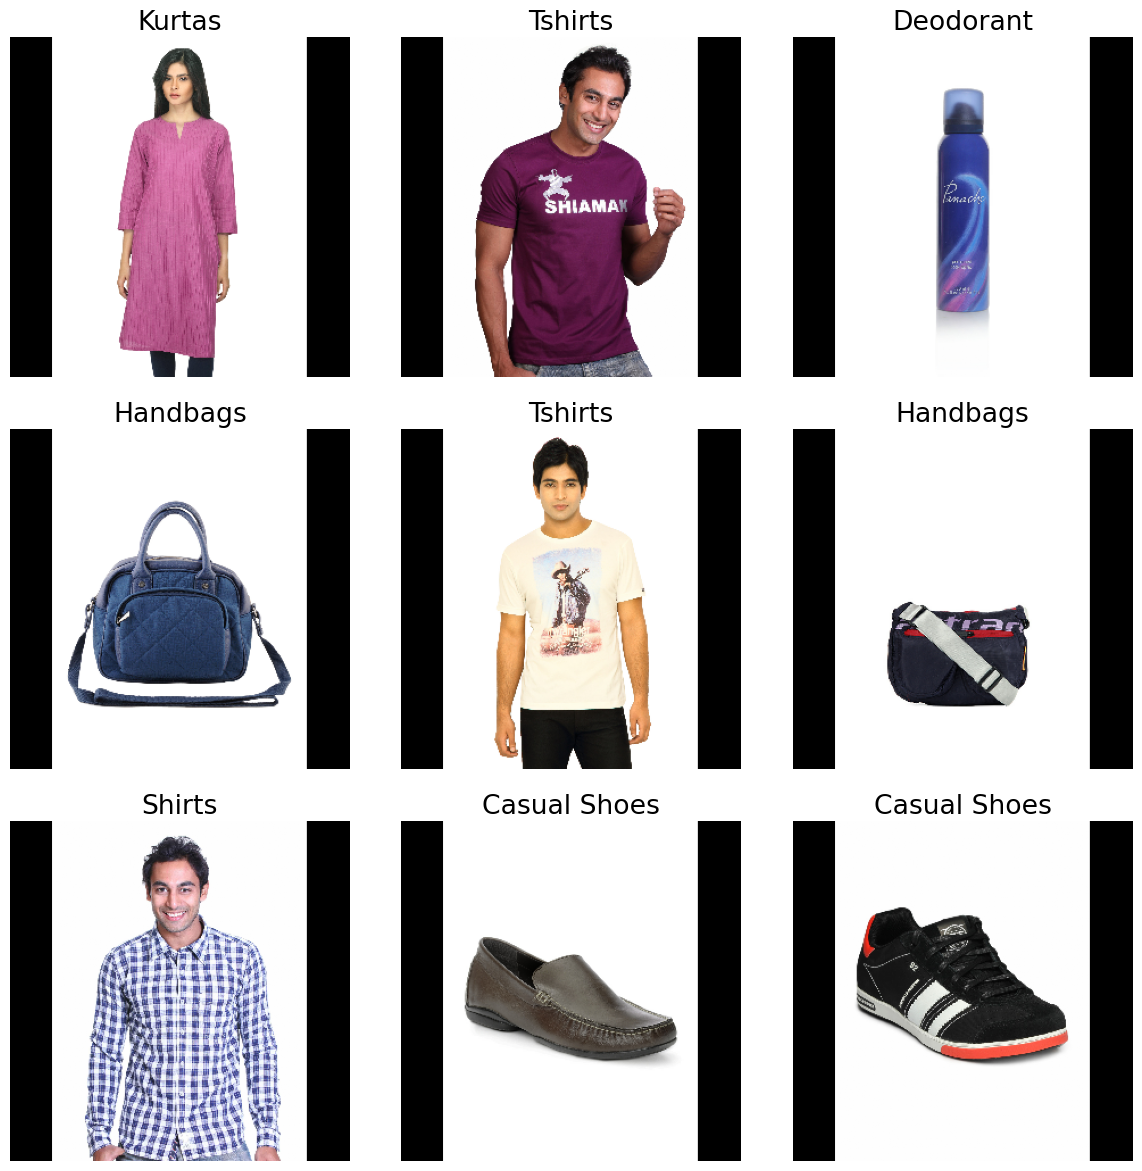


Displaying resized images for InceptionV3:


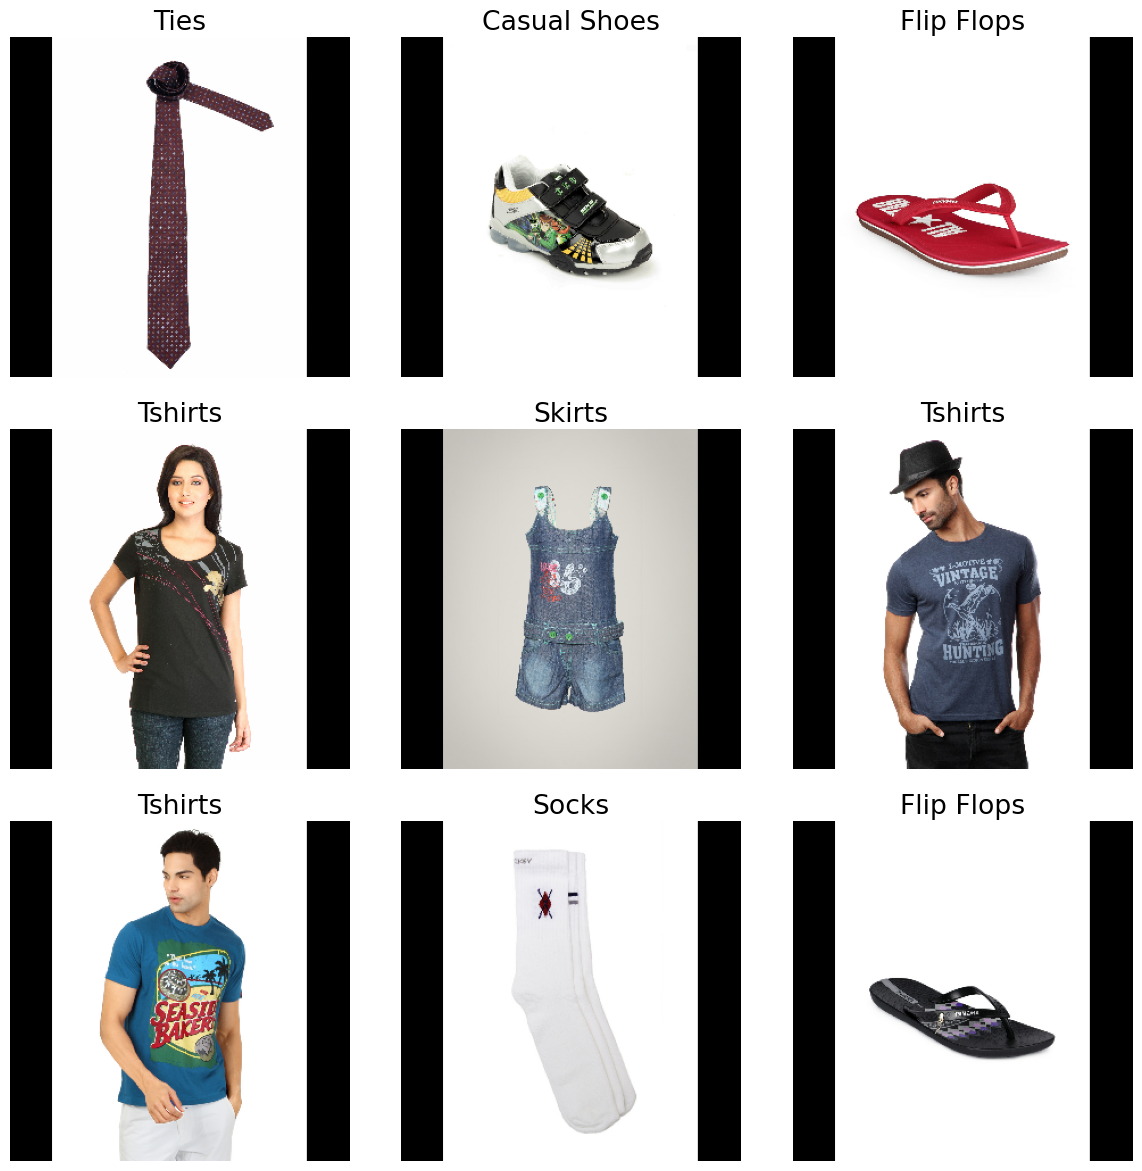

In [6]:
# Configuration
data_dir = "data/"
batch_size = 128
epochs = 30
models = ["EfficientNetV2M", "ResNet50", "Xception", "InceptionV3"]
model_configs = {
    "ResNet50": {"target_size": (224, 224), "preprocess_input": tf.keras.applications.resnet50.preprocess_input},
    "Xception": {"target_size": (299, 299), "preprocess_input": tf.keras.applications.xception.preprocess_input},
    "EfficientNetV2M": {"target_size": (299, 299),"preprocess_input": tf.keras.applications.efficientnet_v2.preprocess_input},
    "InceptionV3": {"target_size": (299, 299), "preprocess_input": tf.keras.applications.inception_v3.preprocess_input},
}

# Load and preprocess data
train_df, val_df, test_df, total_images = load_and_preprocess_data(data_dir)

# Create a pie chart
plt.figure(figsize=(20, 12))  # Increased figure size
sizes = [len(train_df), len(val_df), len(test_df)]
labels = ['Train', 'Validation', 'Test']
colors = sns.color_palette("pastel")[0:3]

plt.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(sizes))})', 
        startangle=90, textprops={'fontsize': 16}, explode=(0.1, 0, 0))
plt.title(f'Distribution of Images in Train, Validation, and Test Sets\nTotal Images: {total_images}', fontsize=22)
plt.axis('equal')

# Add a much larger legend
plt.legend(title="Datasets", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=18, title_fontsize=20, 
           labelspacing=1.5, handlelength=3, handletextpad=1.5)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right margin to accommodate the legend

# Save the pie chart
plt.savefig('artifacts/data_split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Pie chart has been saved as 'data_split_distribution.png'")

# Save test dataset
test_df.to_csv('artifacts/test_dataset.csv', index=False)

# Save model configurations
with open('artifacts/model_configs.json', 'w') as f:
    json.dump({k: {**v, "preprocess_input": v["preprocess_input"].__name__} for k, v in model_configs.items()}, f)

# Save class labels
class_labels = np.unique(train_df["articleType"])
np.save('artifacts/class_labels.npy', class_labels)

# Get a random sample of 9 images
for model_name, config in model_configs.items():
    print(f"\nDisplaying resized images for {model_name}:")

    # Get a random sample of 9 images
    sample_df = train_df.sample(n=9)

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i, (_, row) in enumerate(sample_df.iterrows()):
        img = preprocess_image(row['image'], config['target_size'], config['preprocess_input'])
        img = img.numpy()

        # Denormalize the image for display
        img = (img - np.min(img)) / (np.max(img) - np.min(img))

        ax = axes[i // 3, i % 3]
        ax.imshow(img)
        ax.set_title(row['articleType'])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Exploratory Data Analysis

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB
None
                  id gender masterCategory subCategory articleType baseColour  \
count   44424.000000  44424          44424       44424       44424      44409   
unique           NaN      5              7          4

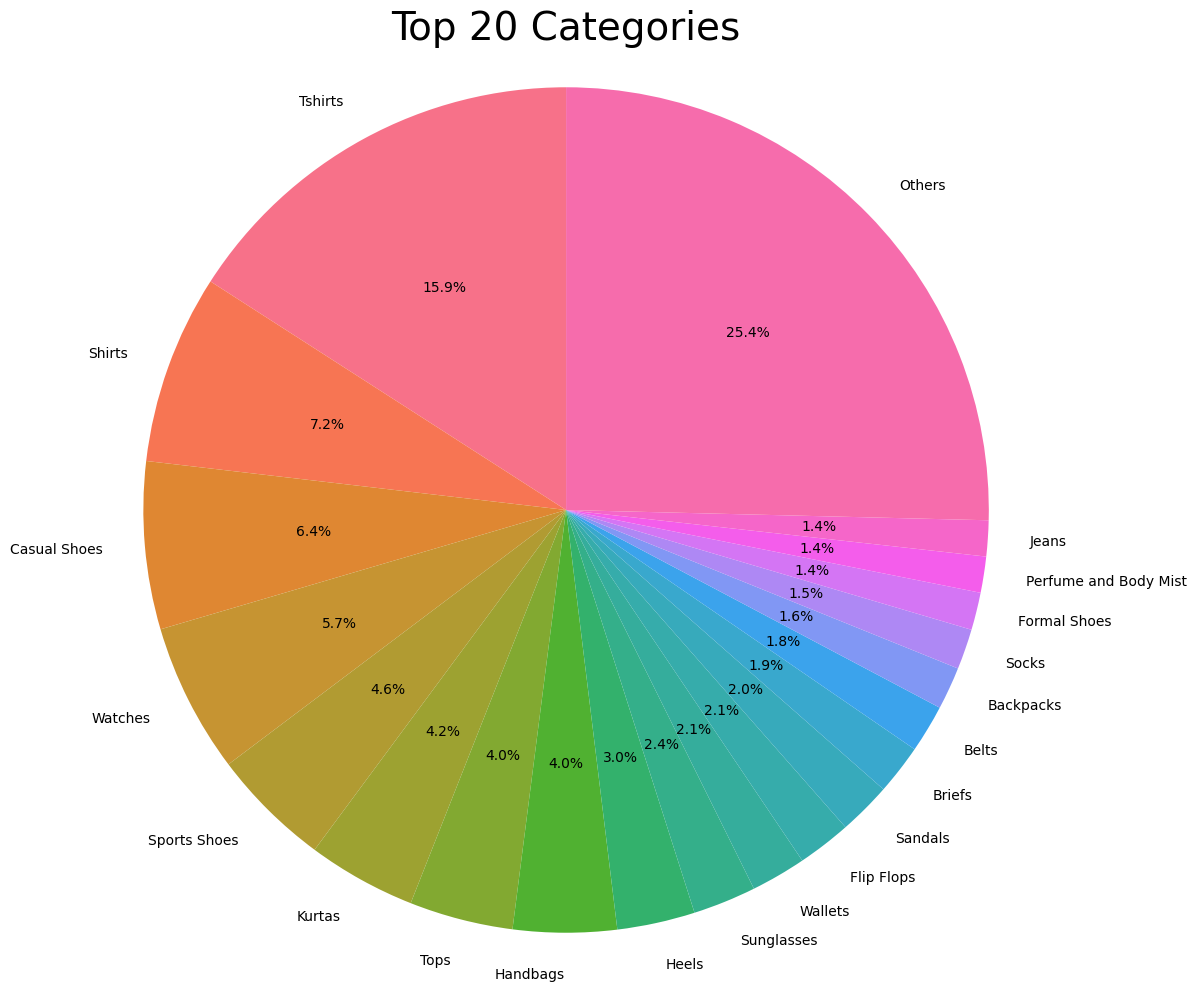

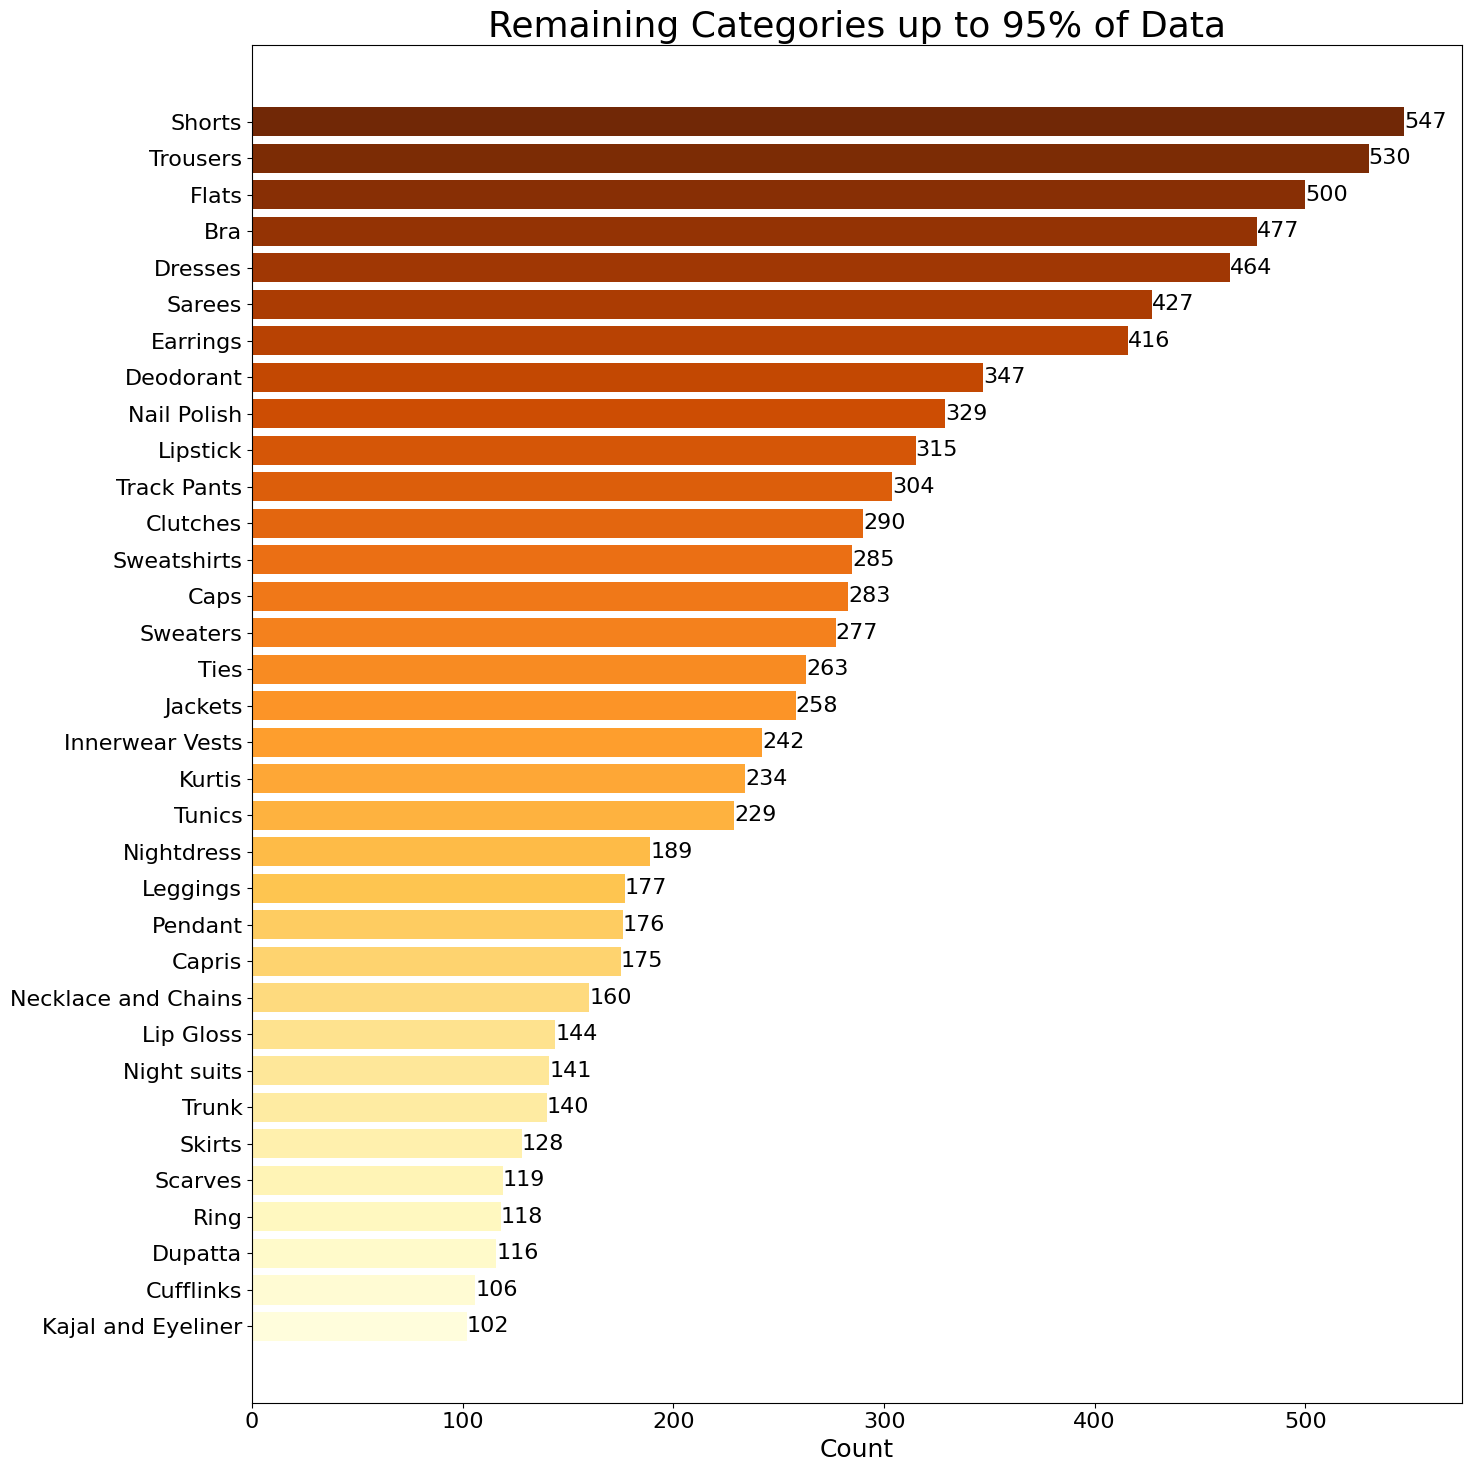

Charts have been saved as 'article_types_distribution_pie.png' and 'article_types_distribution_bar.png'

Classes representing 95% of the data:
1. Tshirts: 7067
2. Shirts: 3217
3. Casual Shoes: 2845
4. Watches: 2542
5. Sports Shoes: 2036
6. Kurtas: 1844
7. Tops: 1762
8. Handbags: 1759
9. Heels: 1323
10. Sunglasses: 1073
11. Wallets: 936
12. Flip Flops: 914
13. Sandals: 897
14. Briefs: 849
15. Belts: 813
16. Backpacks: 724
17. Socks: 686
18. Formal Shoes: 637
19. Perfume and Body Mist: 613
20. Jeans: 609
21. Shorts: 547
22. Trousers: 530
23. Flats: 500
24. Bra: 477
25. Dresses: 464
26. Sarees: 427
27. Earrings: 416
28. Deodorant: 347
29. Nail Polish: 329
30. Lipstick: 315
31. Track Pants: 304
32. Clutches: 290
33. Sweatshirts: 285
34. Caps: 283
35. Sweaters: 277
36. Ties: 263
37. Jackets: 258
38. Innerwear Vests: 242
39. Kurtis: 234
40. Tunics: 229
41. Nightdress: 189
42. Leggings: 177
43. Pendant: 176
44. Capris: 175
45. Necklace and Chains: 160
46. Lip Gloss: 144
47. Night suits: 141
4

In [3]:
# Load the dataset
file_path = 'data/styles.csv'
eda_df = pd.read_csv(file_path, on_bad_lines='skip')
eda_df = eda_df[['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']]

# Display basic information about the dataset
print("Dataset Information:")
print(eda_df.info())
print(eda_df.describe(include='all'))

print("\nFirst few rows of the dataset:")
print(eda_df.head())

# Number of unique values in each column
print("\nNumber of unique values in each column:")
print(eda_df.nunique())


# Count the occurrences of each articleType
article_counts = eda_df['articleType'].value_counts()

# Total number of classes before preprocessing
total_classes = len(article_counts)

print(f"Total number of classes in 'articleType' before preprocessing: {total_classes}")

# Calculate the cumulative percentage
cumulative_percentage = 100 * article_counts.cumsum() / article_counts.sum()

# Find the number of classes that represent 95% of the data
classes_95_percent = (cumulative_percentage <= 95).sum()

print(f"Number of classes in 'articleType' representing 95% of the data: {classes_95_percent}")

def create_pie_and_bar_chart(data, title, filename, top_n=20):
    # Pie chart
    plt.figure(figsize=(12, 12))  
    top_categories = data.head(top_n)
    others = pd.Series({'Others': data.iloc[top_n:].sum()})
    pie_data = pd.concat([top_categories, others])
    
    colors = sns.color_palette("husl", len(pie_data))
    plt.pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title(f'Top {top_n} Categories', fontsize=28)  
    plt.axis('equal')
    
    # Increase font size for pie chart labels and percentages
    plt.rcParams['font.size'] = 16  
    
    plt.savefig(f'artifacts/{filename}_pie.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # Bar chart
    plt.figure(figsize=(15, 15))  
    remaining_categories = data.iloc[top_n:classes_95_percent]
    remaining_categories = remaining_categories.sort_values(ascending=True)
    
    colors = sns.color_palette("YlOrBr", len(remaining_categories))
    bars = plt.barh(range(len(remaining_categories)), remaining_categories.values, color=colors)
    plt.yticks(range(len(remaining_categories)), remaining_categories.index, fontsize=16)  
    plt.xlabel('Count', fontsize=18)  
    plt.title(f'Remaining Categories up to 95% of Data', fontsize=26)  
    
    # Add value labels to the end of each bar
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
                 ha='left', va='center', fontsize=16)  
    
    plt.tight_layout()
    plt.savefig(f'artifacts/{filename}_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
# Create charts for all classes up to 95%
create_pie_and_bar_chart(article_counts, 'Distribution of Article Types (95% of Data)', 'article_types_distribution')

print(f"Charts have been saved as 'article_types_distribution_pie.png' and 'article_types_distribution_bar.png'")

# Optional: Print the classes representing 95% of the data
classes = article_counts.index[:classes_95_percent].tolist()
print("\nClasses representing 95% of the data:")
for i, class_name in enumerate(classes, 1):
    print(f"{i}. {class_name}: {article_counts[class_name]}")



# Model Training

In [7]:
# Detect and connect to a TPU if available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU ", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

# Train and evaluate models
histories = {}
for model_name in models:
    print(f"Training {model_name} model...")

    config = model_configs[model_name]
    train_dataset = create_dataset(
        train_df,
        batch_size,
        config["target_size"],
        config["preprocess_input"],
        is_training=True,
    )
    val_dataset = create_dataset(
        val_df, batch_size, config["target_size"], config["preprocess_input"]
    )

    with strategy.scope():
        model = build_model(model_name, (*config["target_size"], 3), len(class_labels))
        history = train_model(model, model_name, train_dataset, val_dataset, epochs)
        histories[model_name] = history

    # Save training history
    with open(f'artifacts/history_{model_name}.pkl', 'wb') as f:
        pickle.dump(history.history, f)



Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/

I0000 00:00:1720041137.427257      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/30


2024-07-03 21:16:28.374849: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1720041396.569133     843 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8c29a8007cc9a00b:0:0), session_name()
I0000 00:00:1720041473.453448     843 tpu_compile_op_common.cc:245] Compilation of 8c29a8007cc9a00b:0:0 with session name  took 1m16.884222411s and succeeded
I0000 00:00:1720041473.693591     843 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8c29a8007cc9a00b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5403605055434214667", property.function_library_fingerprint = 2661816121824294792, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z

263/264 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.4579 - loss: 2.3372

I0000 00:00:1720041565.755128     802 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b5fd2b1d57307632:0:0), session_name()
I0000 00:00:1720041640.671894     802 tpu_compile_op_common.cc:245] Compilation of b5fd2b1d57307632:0:0 with session name  took 1m14.916691371s and succeeded
I0000 00:00:1720041640.976958     802 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b5fd2b1d57307632:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5403605055434214667", property.function_library_fingerprint = 2661816121824294792, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "7,299,299,3,;7,54,;", property.guaranteed_constants_size = 0, em

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.4585 - loss: 2.3343

2024-07-03 21:20:50.040005: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.
I0000 00:00:1720041652.243541     755 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(20e8c6b67fec64dc:0:0), session_name()
I0000 00:00:1720041662.737822     755 tpu_compile_op_common.cc:245] Compilation of 20e8c6b67fec64dc:0:0 with session name  took 10.494223406s and succeeded
I0000 00:00:1720041662.770875     755 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(20e8c6b67fec64dc:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15863041185164534592", property.function_library_fingerprint = 6174430672780716002, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, to


Epoch 1: val_accuracy improved from -inf to 0.80645, saving model to best_model_EfficientNetV2M.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 546s 797ms/step - accuracy: 0.4591 - loss: 2.3314 - val_accuracy: 0.8065 - val_loss: 0.6566 - learning_rate: 1.0000e-04
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8063 - loss: 0.6716
Epoch 2: val_accuracy improved from 0.80645 to 0.85389, saving model to best_model_EfficientNetV2M.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 106s 396ms/step - accuracy: 0.8063 - loss: 0.6714 - val_accuracy: 0.8539 - val_loss: 0.3946 - learning_rate: 1.0000e-04
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8500 - loss: 0.4865
Epoch 3: val_accuracy improved from 0.85389 to 0.88615, saving model to best_model_EfficientNetV2M.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 108s 405ms/step - accuracy: 0.8500 - loss: 0.4864 - val_accuracy: 0.8861 - val_loss: 0.3636 - learning_rate: 1.0000e-04
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy

2024-07-03 22:11:06.942839: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1720044669.241829     757 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(46ba6970c543a632:0:0), session_name()


  1/264 ━━━━━━━━━━━━━━━━━━━━ 7:15:52 99s/step - accuracy: 0.0000e+00 - loss: 4.3018

I0000 00:00:1720044685.987676     757 tpu_compile_op_common.cc:245] Compilation of 46ba6970c543a632:0:0 with session name  took 16.745770018s and succeeded
I0000 00:00:1720044686.050363     757 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(46ba6970c543a632:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4025581645291460506", property.function_library_fingerprint = 18095313053252346903, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16,224,224,3,;16,54,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1720044686.050404     757 tpu_compilation_cache_interface.cc:541] After adding entry for k

263/264 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5401 - loss: 1.8980

I0000 00:00:1720044720.166895     814 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(eab46606fc9ea964:0:0), session_name()


264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5407 - loss: 1.8955

I0000 00:00:1720044737.730027     814 tpu_compile_op_common.cc:245] Compilation of eab46606fc9ea964:0:0 with session name  took 17.563094431s and succeeded
I0000 00:00:1720044737.794948     814 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(eab46606fc9ea964:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4025581645291460506", property.function_library_fingerprint = 18095313053252346903, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "7,224,224,3,;7,54,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1720044737.794989     814 tpu_compilation_cache_interface.cc:541] After adding entry for key


Epoch 1: val_accuracy improved from -inf to 0.77799, saving model to best_model_ResNet50.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 168s 261ms/step - accuracy: 0.5412 - loss: 1.8931 - val_accuracy: 0.7780 - val_loss: 0.7958 - learning_rate: 1.0000e-04
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7973 - loss: 0.6637
Epoch 2: val_accuracy improved from 0.77799 to 0.83112, saving model to best_model_ResNet50.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.7973 - loss: 0.6636 - val_accuracy: 0.8311 - val_loss: 0.6459 - learning_rate: 1.0000e-04
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8483 - loss: 0.5154
Epoch 3: val_accuracy improved from 0.83112 to 0.86148, saving model to best_model_ResNet50.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - accuracy: 0.8483 - loss: 0.5153 - val_accuracy: 0.8615 - val_loss: 0.4767 - learning_rate: 1.0000e-04
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8337 - loss: 0.5149

2024-07-03 22:31:24.985870: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1720045886.788134     814 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(7c2cc6a75fba5416:0:0), session_name()
I0000 00:00:1720045905.876858     814 tpu_compile_op_common.cc:245] Compilation of 7c2cc6a75fba5416:0:0 with session name  took 19.088659824s and succeeded
I0000 00:00:1720045905.936464     814 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7c2cc6a75fba5416:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_12481874870569511409", property.function_library_fingerprint = 10412373731944580030, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z

263/264 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5086 - loss: 2.0334

I0000 00:00:1720045954.687490     749 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(4f40e8351da38207:0:0), session_name()


264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.5092 - loss: 2.0306

I0000 00:00:1720045970.672585     749 tpu_compile_op_common.cc:245] Compilation of 4f40e8351da38207:0:0 with session name  took 15.985053317s and succeeded
I0000 00:00:1720045970.730970     749 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(4f40e8351da38207:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_12481874870569511409", property.function_library_fingerprint = 10412373731944580030, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "7,299,299,3,;7,54,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1720045970.731017     749 tpu_compilation_cache_interface.cc:541] After adding entry for ke


Epoch 1: val_accuracy improved from -inf to 0.79886, saving model to best_model_Xception.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 169s 334ms/step - accuracy: 0.5098 - loss: 2.0278 - val_accuracy: 0.7989 - val_loss: 0.5671 - learning_rate: 1.0000e-04
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8209 - loss: 0.5751
Epoch 2: val_accuracy improved from 0.79886 to 0.85579, saving model to best_model_Xception.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 57s 214ms/step - accuracy: 0.8209 - loss: 0.5751 - val_accuracy: 0.8558 - val_loss: 0.4253 - learning_rate: 1.0000e-04
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8528 - loss: 0.4764
Epoch 3: val_accuracy improved from 0.85579 to 0.89753, saving model to best_model_Xception.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 58s 217ms/step - accuracy: 0.8528 - loss: 0.4763 - val_accuracy: 0.8975 - val_loss: 0.3215 - learning_rate: 1.0000e-04
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8803 - loss: 0.3647

2024-07-03 22:58:40.631467: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1720047523.224041     778 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6ed9096ca113591d:0:0), session_name()
I0000 00:00:1720047553.762996     778 tpu_compile_op_common.cc:245] Compilation of 6ed9096ca113591d:0:0 with session name  took 30.538828165s and succeeded
I0000 00:00:1720047553.866004     778 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6ed9096ca113591d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5626706578915508108", property.function_library_fingerprint = 8793682681003896674, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z =

263/264 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5226 - loss: 1.9407

I0000 00:00:1720047603.474712     830 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(eafc0db3e438af4e:0:0), session_name()
I0000 00:00:1720047632.352298     830 tpu_compile_op_common.cc:245] Compilation of eafc0db3e438af4e:0:0 with session name  took 28.877547017s and succeeded
I0000 00:00:1720047632.452969     830 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(eafc0db3e438af4e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_5626706578915508108", property.function_library_fingerprint = 8793682681003896674, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "7,299,299,3,;7,54,;", property.guaranteed_constants_size = 0, embe

264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5232 - loss: 1.9383

2024-07-03 23:00:35.877163: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignVariableOp.
I0000 00:00:1720047636.762750     800 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d7fb7cec06866587:0:0), session_name()
I0000 00:00:1720047646.696667     800 tpu_compile_op_common.cc:245] Compilation of d7fb7cec06866587:0:0 with session name  took 9.933863629s and succeeded
I0000 00:00:1720047646.725648     800 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d7fb7cec06866587:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_916147575062521127", property.function_library_fingerprint = 1430495001175392793, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topol


Epoch 1: val_accuracy improved from -inf to 0.73245, saving model to best_model_InceptionV3.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 225s 421ms/step - accuracy: 0.5237 - loss: 1.9359 - val_accuracy: 0.7324 - val_loss: 0.7970 - learning_rate: 1.0000e-04
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7887 - loss: 0.7072
Epoch 2: val_accuracy improved from 0.73245 to 0.83112, saving model to best_model_InceptionV3.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 57s 215ms/step - accuracy: 0.7887 - loss: 0.7070 - val_accuracy: 0.8311 - val_loss: 0.5488 - learning_rate: 1.0000e-04
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8287 - loss: 0.5804
Epoch 3: val_accuracy improved from 0.83112 to 0.85389, saving model to best_model_InceptionV3.keras
264/264 ━━━━━━━━━━━━━━━━━━━━ 58s 216ms/step - accuracy: 0.8288 - loss: 0.5802 - val_accuracy: 0.8539 - val_loss: 0.4677 - learning_rate: 1.0000e-04
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8466 - los

# Evaluation

Evaluating EfficientNetV2M model...
33/33 ━━━━━━━━━━━━━━━━━━━━ 322s 9s/step - accuracy: 0.9378 - loss: 0.2414
33/33 ━━━━━━━━━━━━━━━━━━━━ 336s 10s/step
EfficientNetV2M Test Loss: 0.2559
EfficientNetV2M Test Accuracy: 93.31%
Evaluating ResNet50 model...
33/33 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9162 - loss: 0.2421
33/33 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step
ResNet50 Test Loss: 0.2532
ResNet50 Test Accuracy: 91.70%
Evaluating Xception model...
33/33 ━━━━━━━━━━━━━━━━━━━━ 175s 5s/step - accuracy: 0.9275 - loss: 0.2512
33/33 ━━━━━━━━━━━━━━━━━━━━ 175s 5s/step
Xception Test Loss: 0.2732
Xception Test Accuracy: 92.36%
Evaluating InceptionV3 model...
33/33 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9256 - loss: 0.2427
33/33 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step
InceptionV3 Test Loss: 0.2608
InceptionV3 Test Accuracy: 92.15%
Classification Report for EfficientNetV2M:
                       precision    recall  f1-score   support

            Backpacks       1.00      0.93      0.96        72

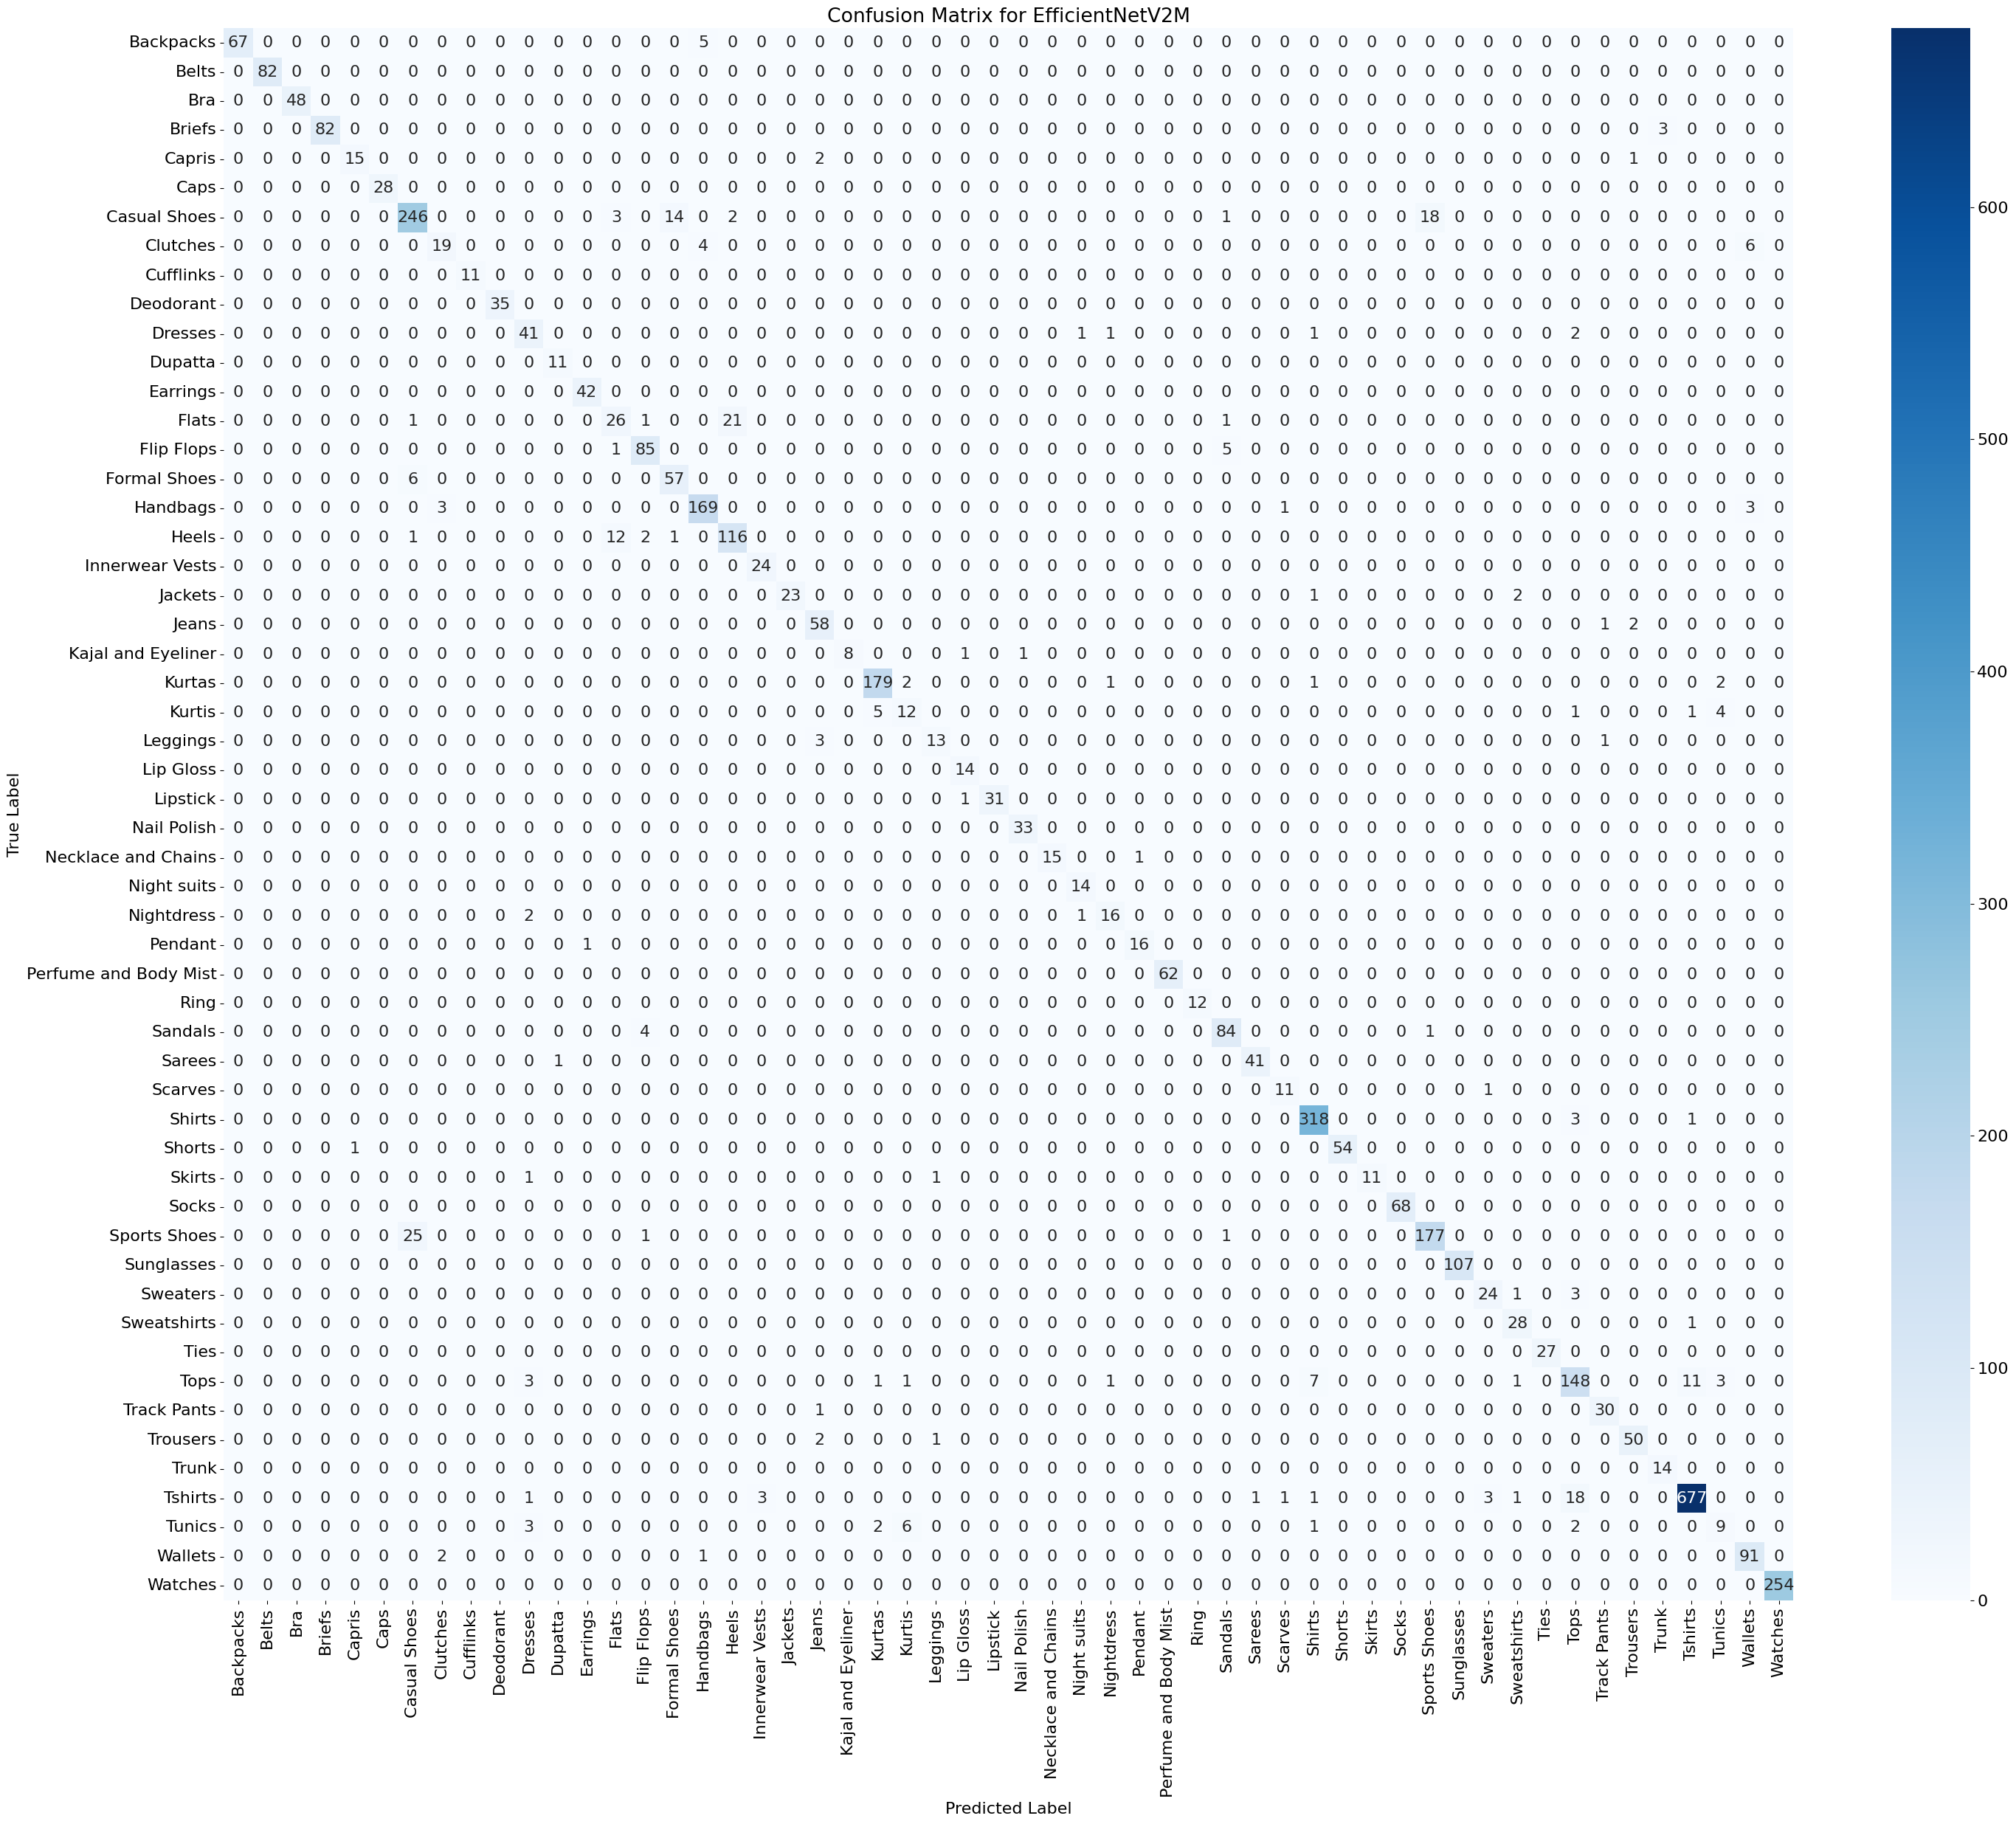

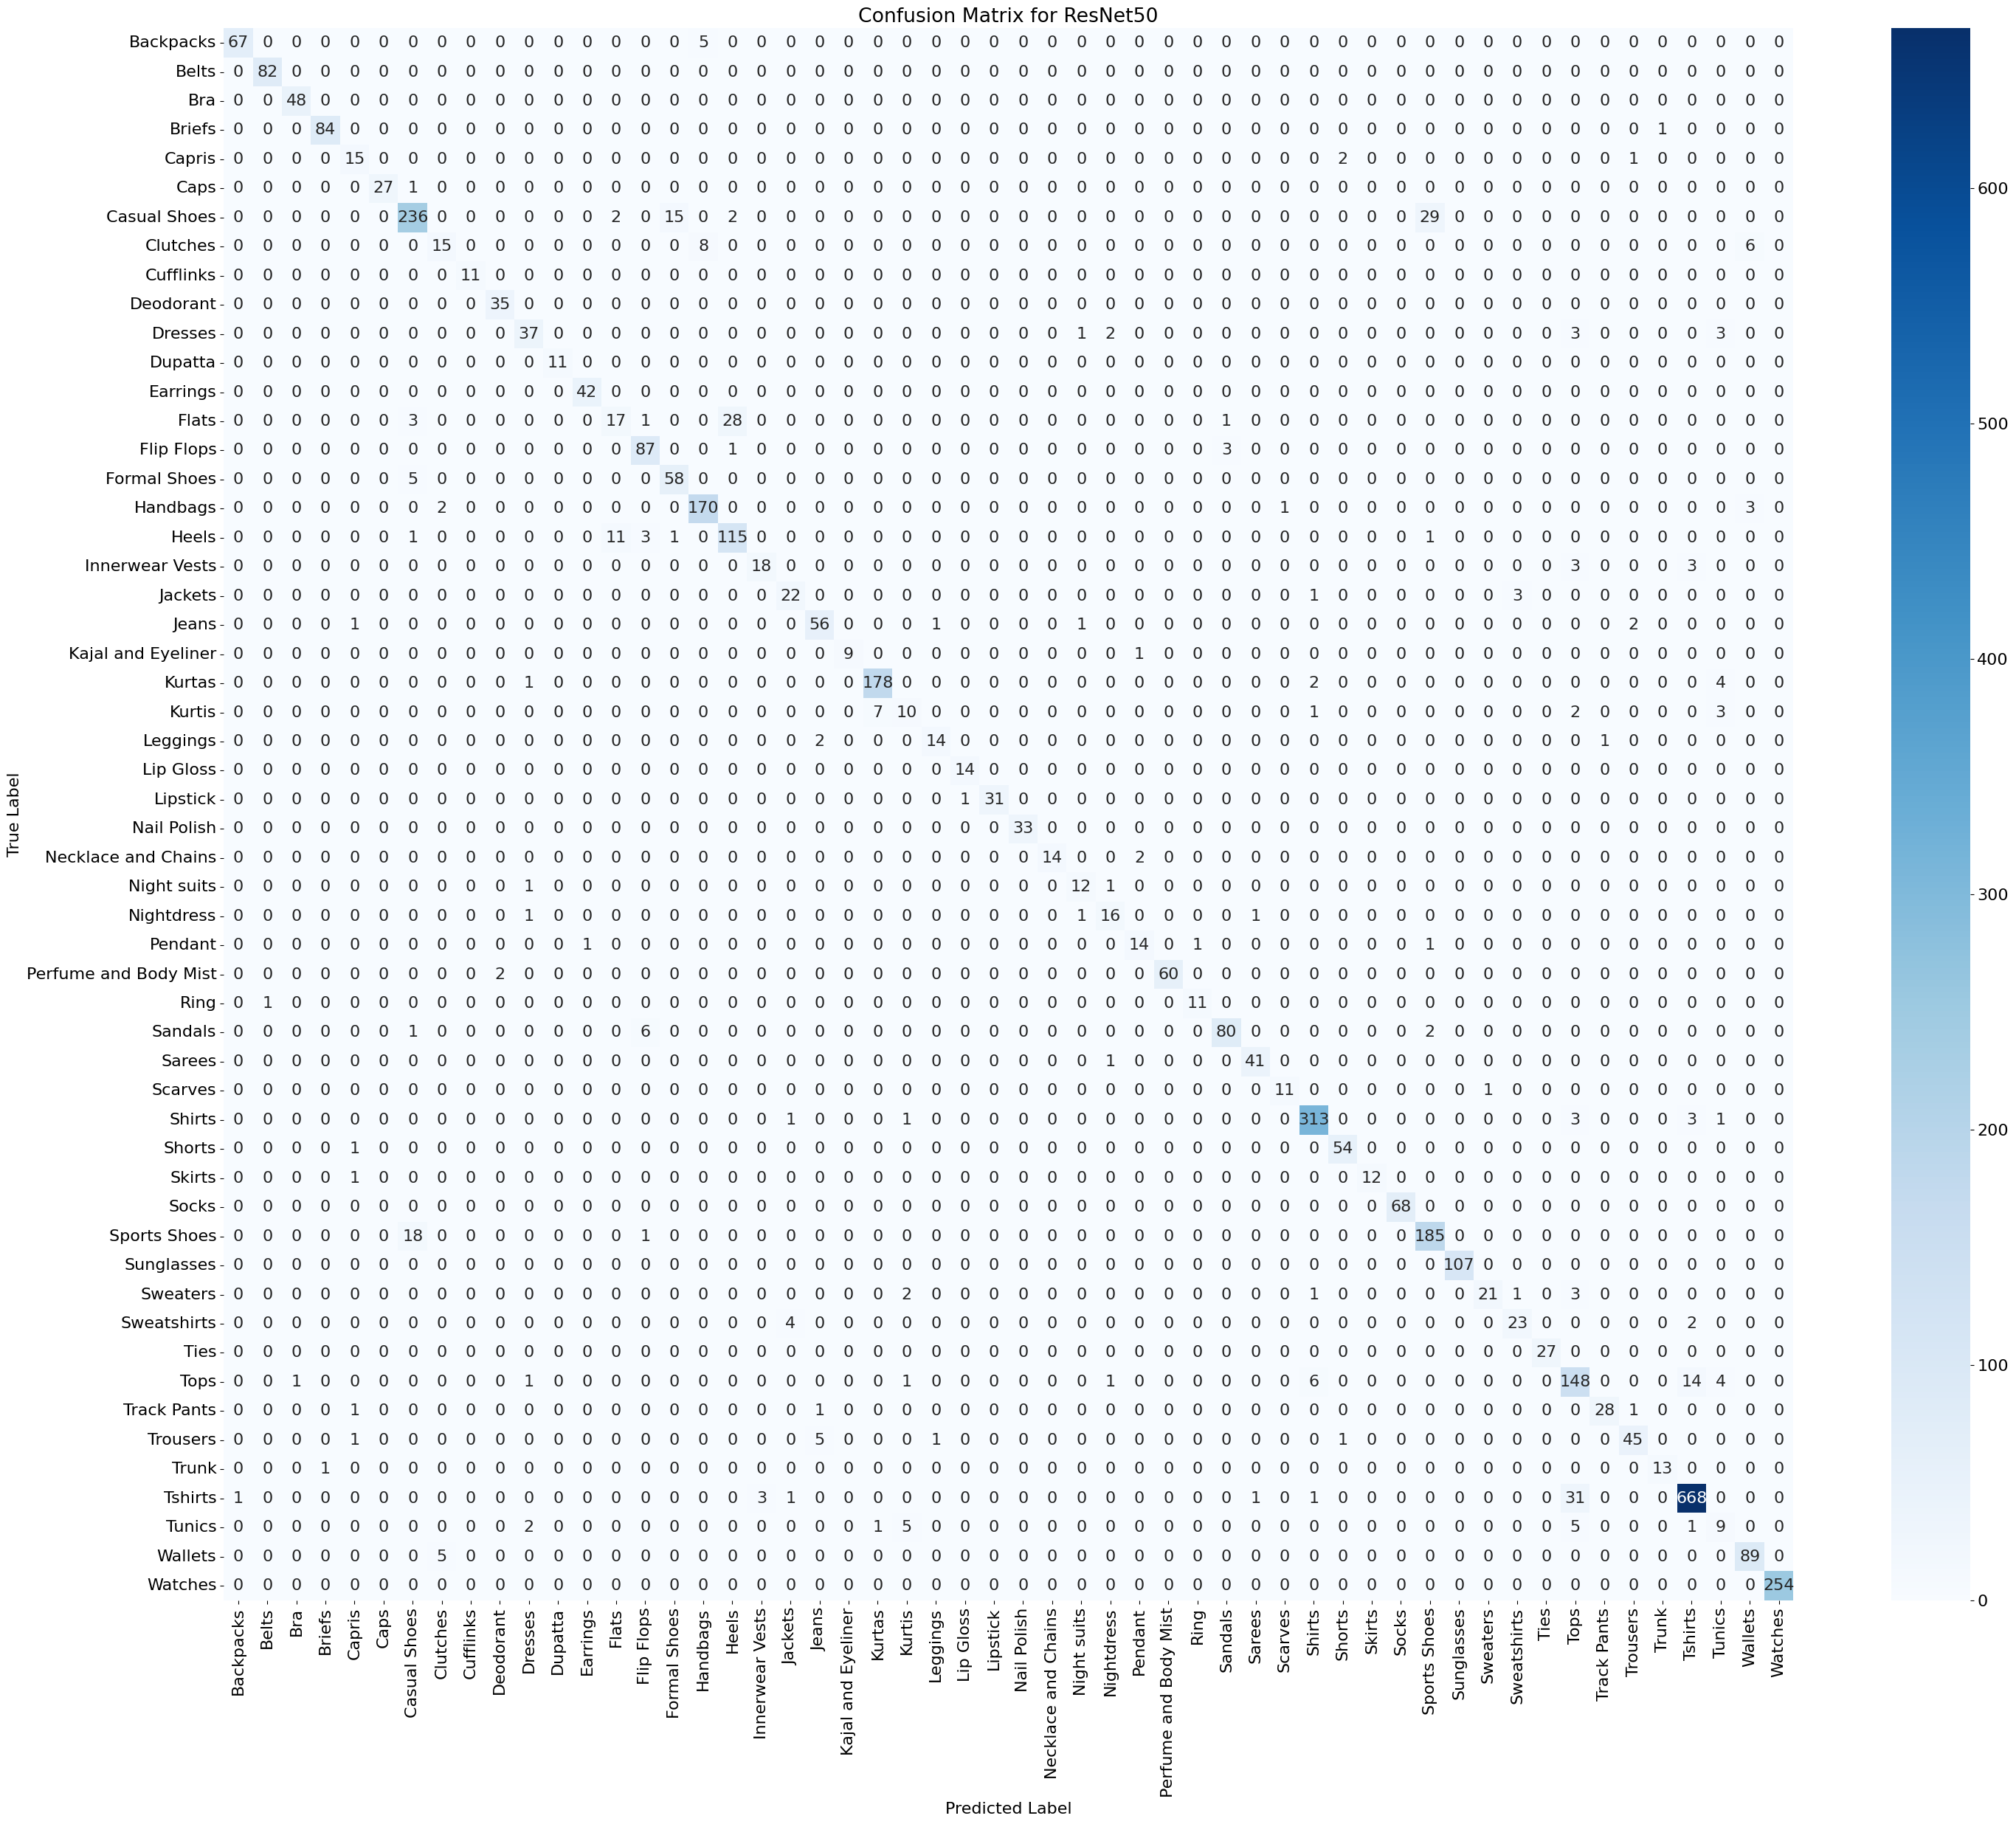

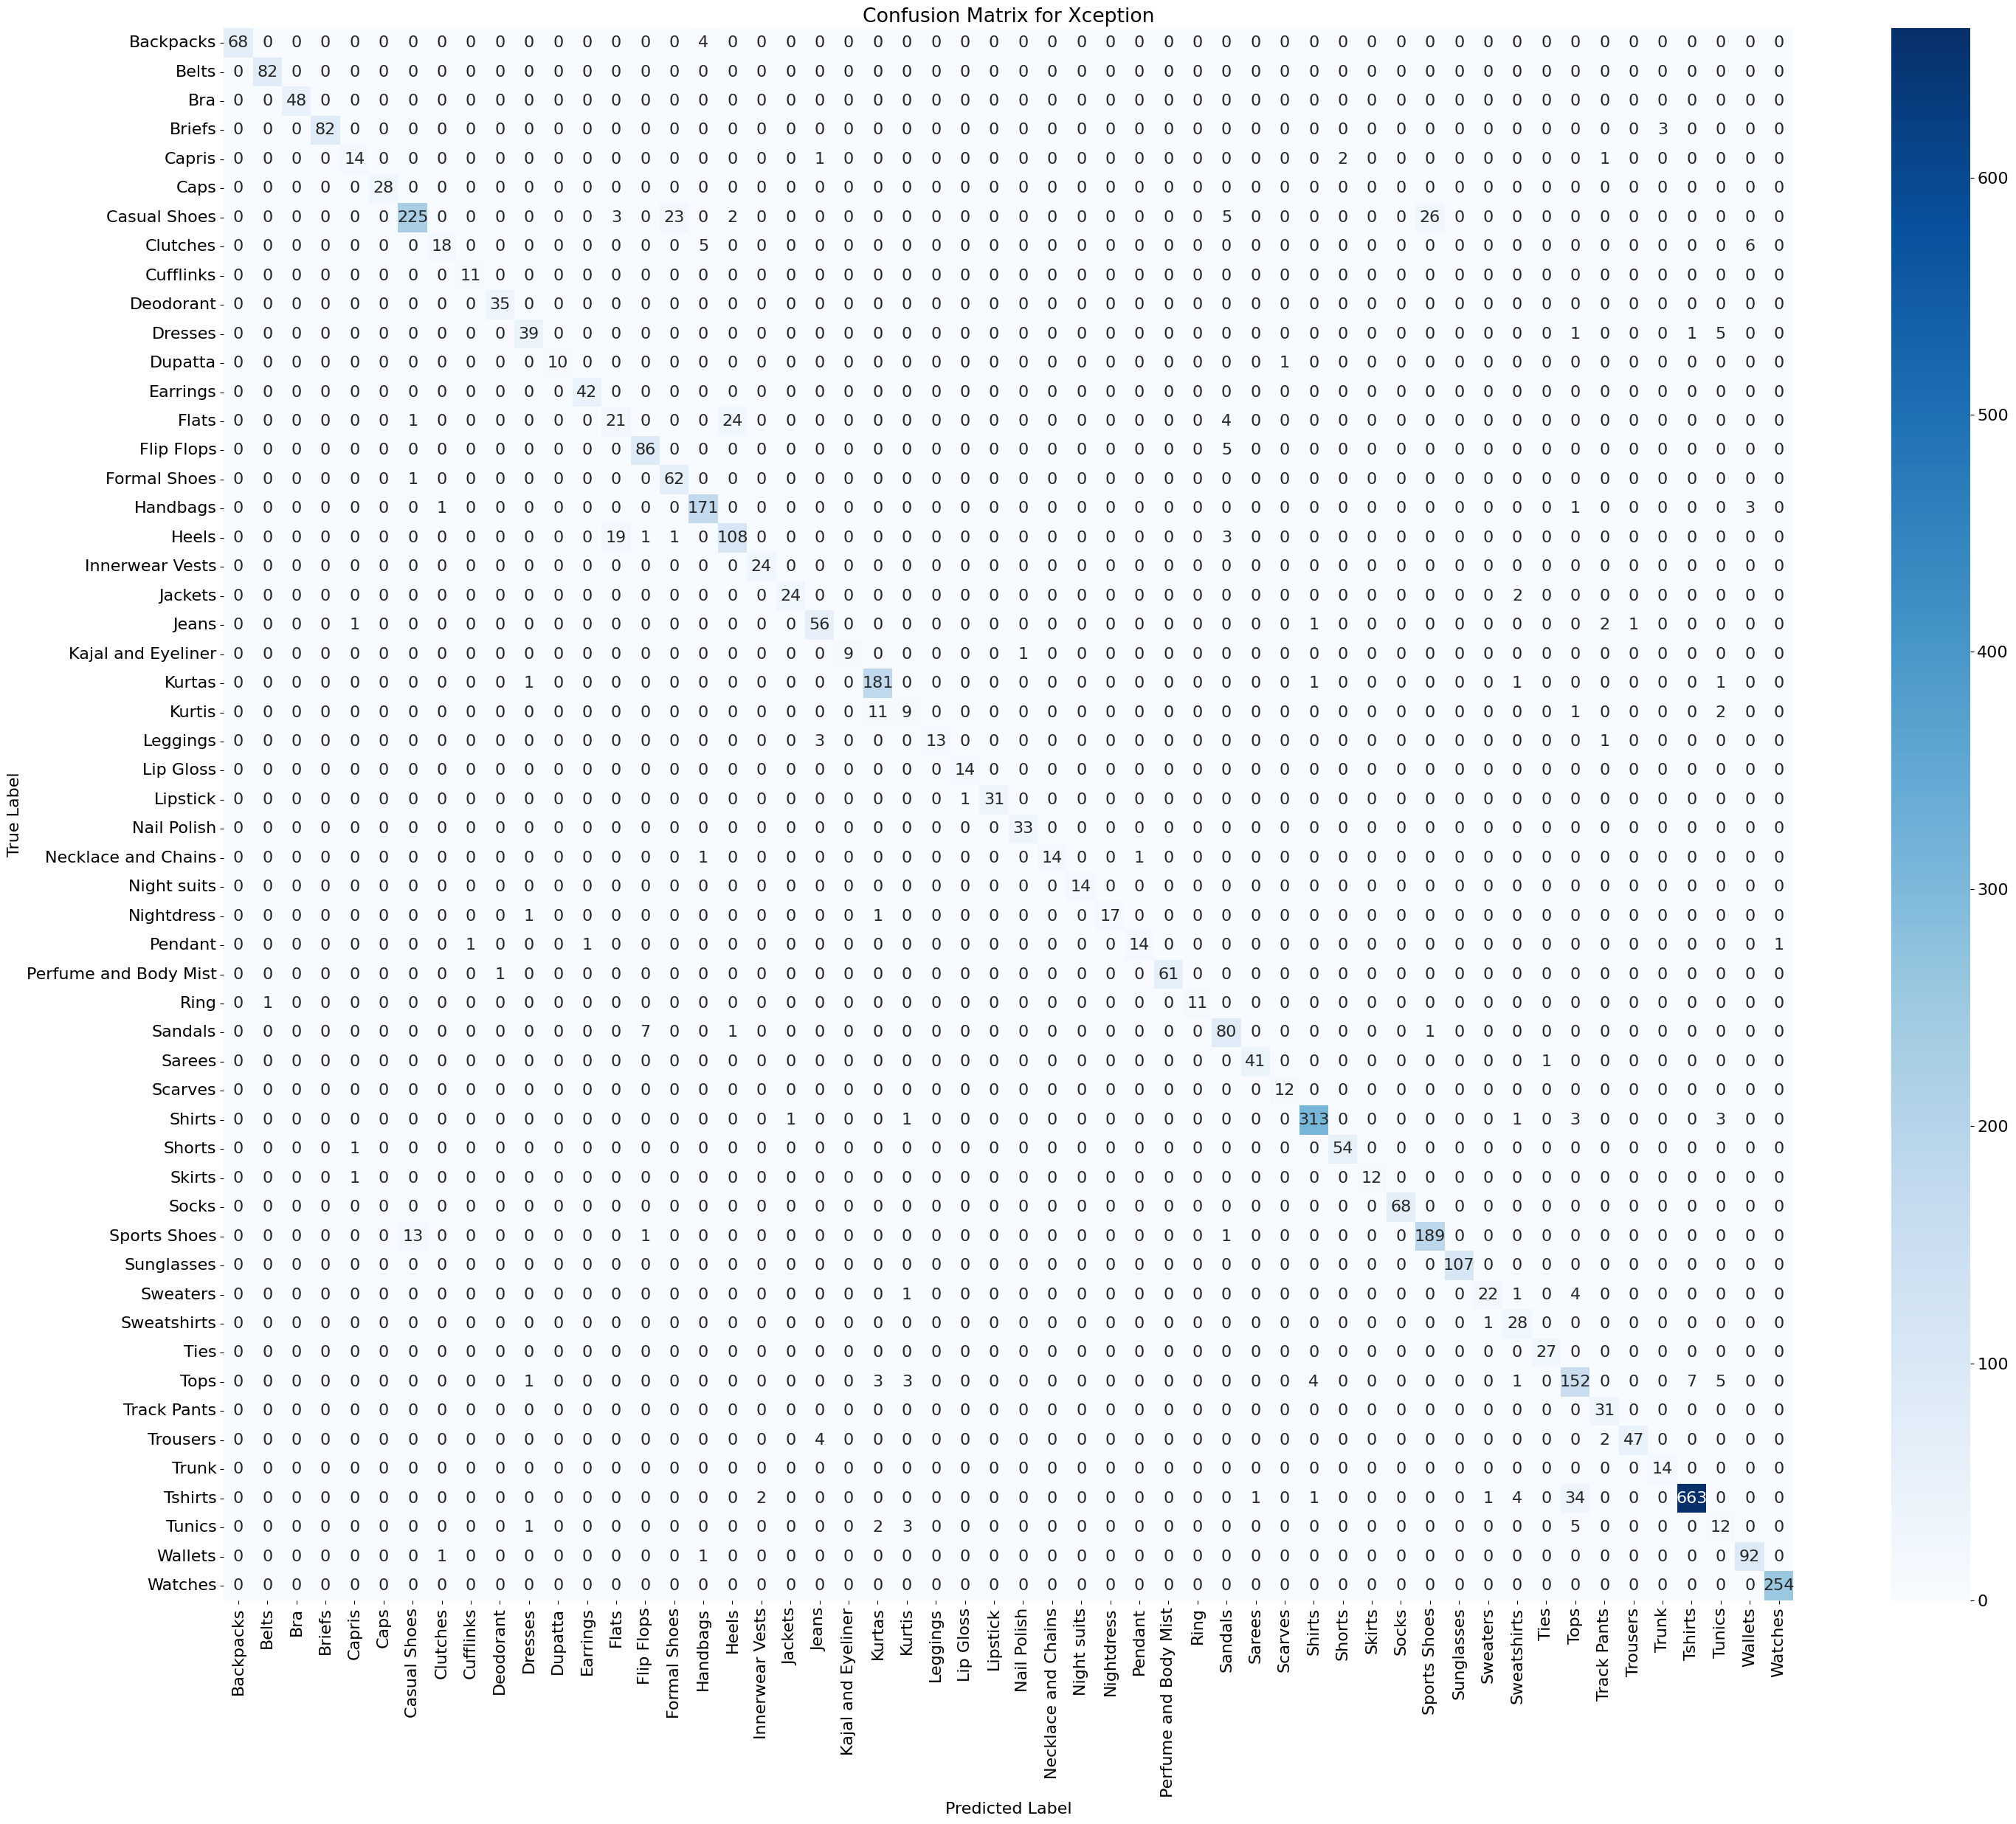

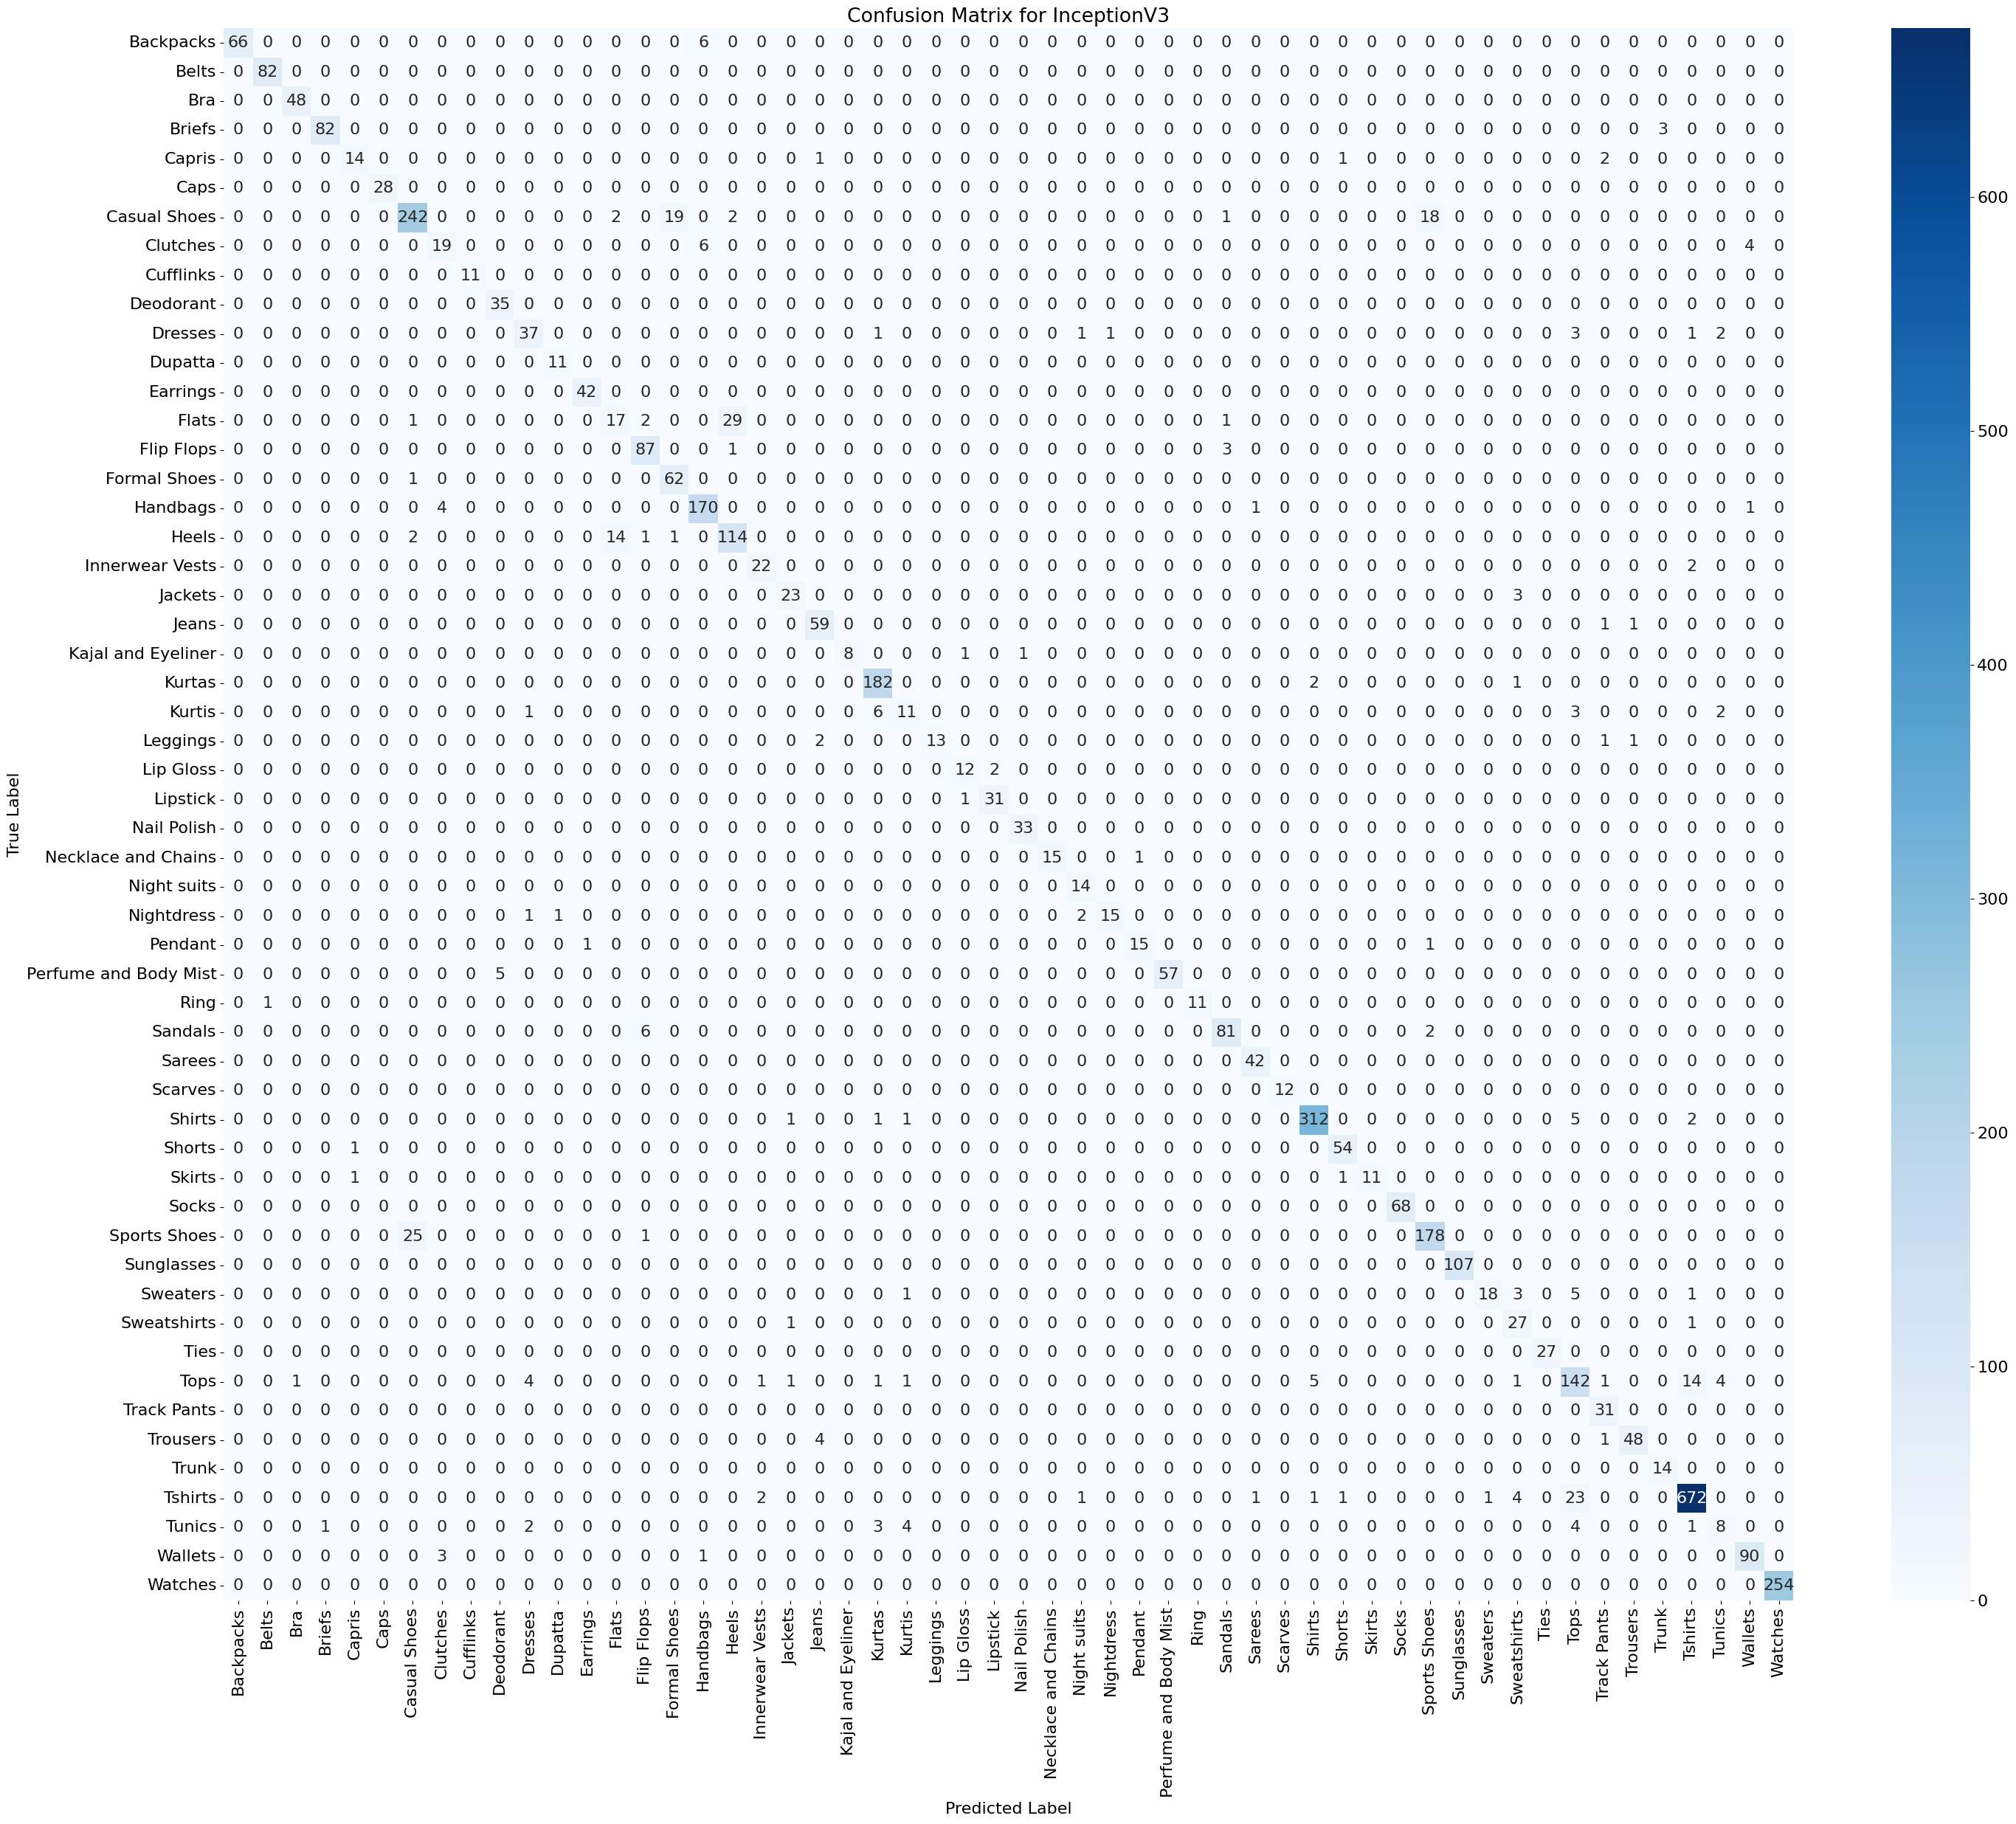

Model Performance Comparison:
EfficientNetV2M: Test Loss = 0.2559, Test Accuracy = 93.31%
ResNet50: Test Loss = 0.2532, Test Accuracy = 91.70%
Xception: Test Loss = 0.2732, Test Accuracy = 92.36%
InceptionV3: Test Loss = 0.2608, Test Accuracy = 92.15%


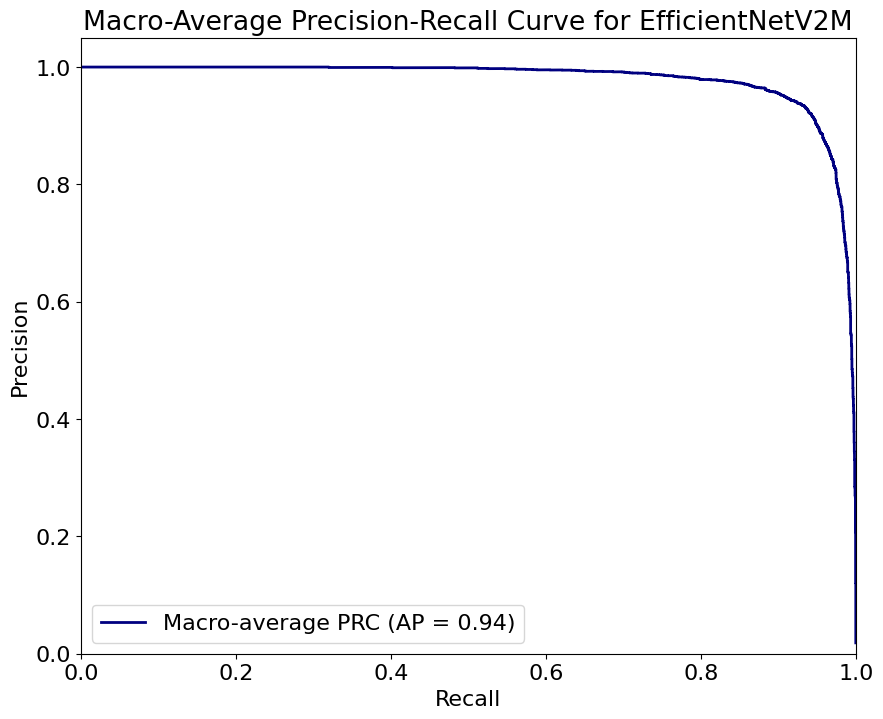

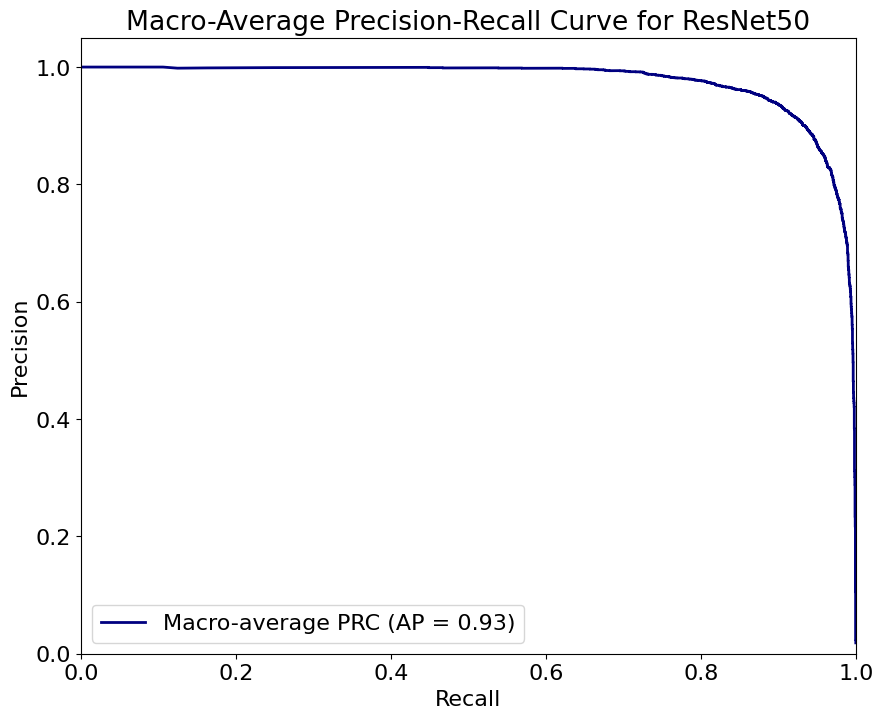

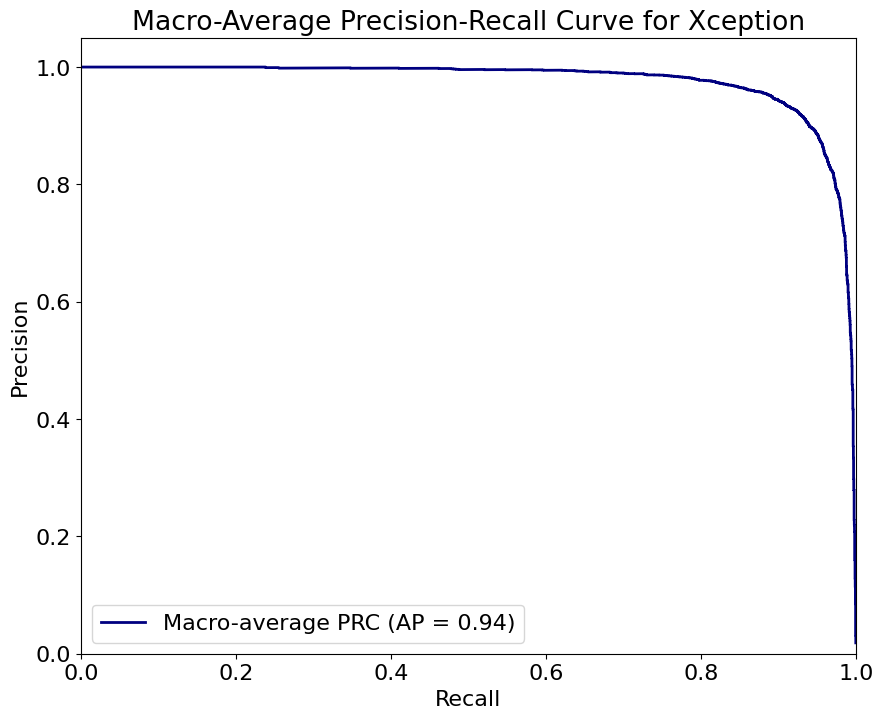

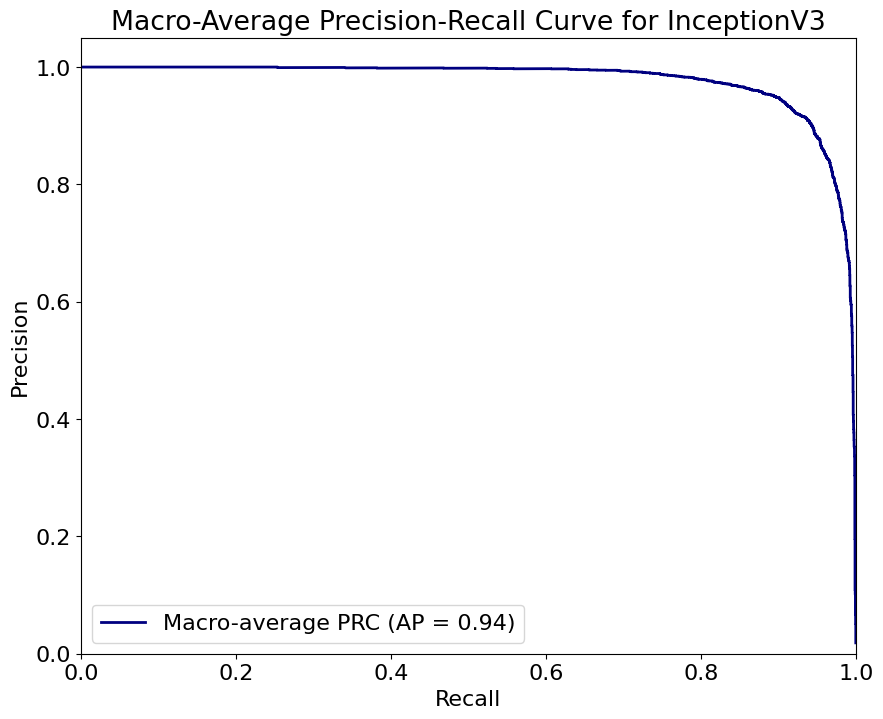


Macro-Average AUPRC Scores:
EfficientNetV2M: 0.9408
ResNet50: 0.9342
Xception: 0.9402
InceptionV3: 0.9390


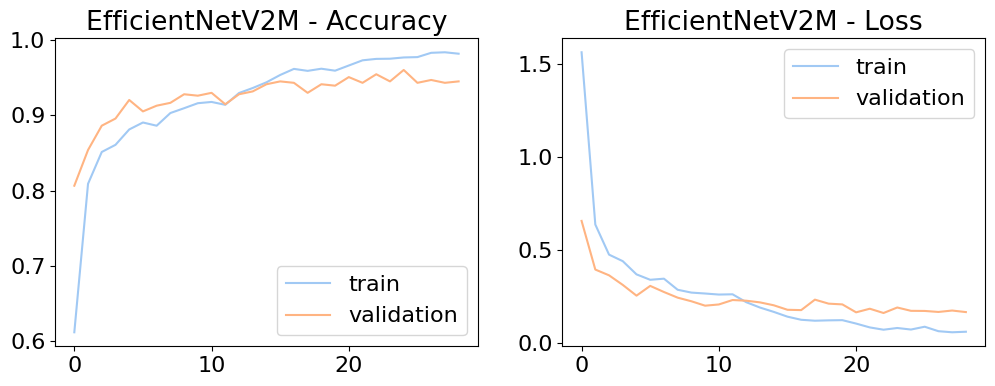

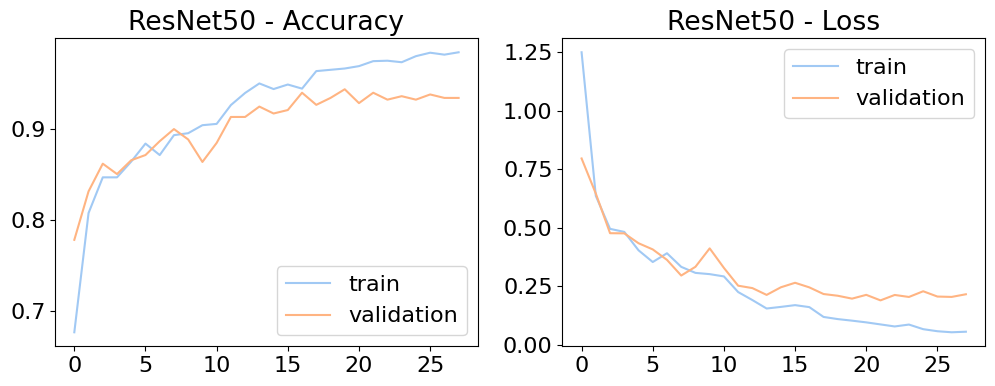

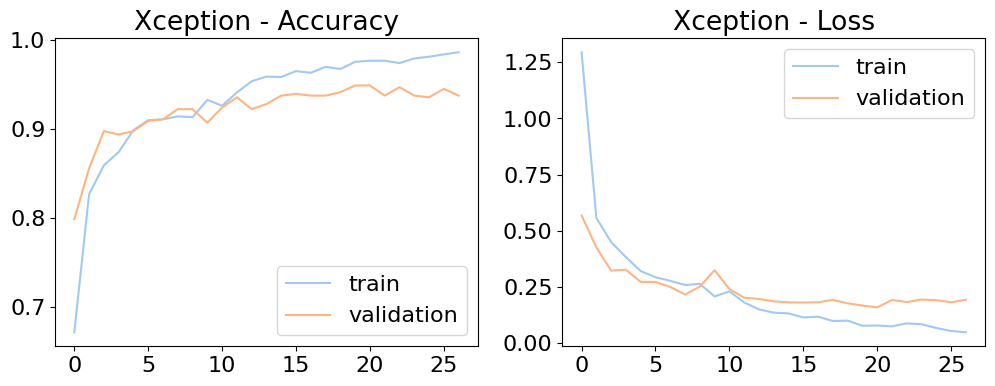

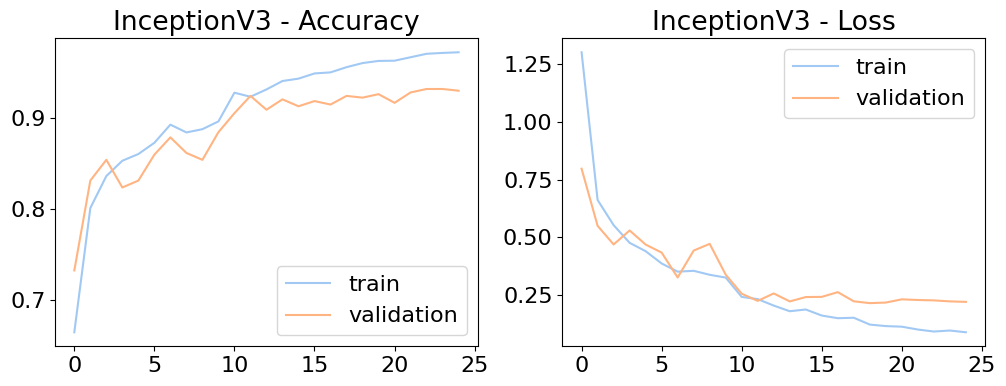

Evaluation completed for all models.
Class labels: ['Backpacks' 'Belts' 'Bra' 'Briefs' 'Capris' 'Caps' 'Casual Shoes'
 'Clutches' 'Cufflinks' 'Deodorant' 'Dresses' 'Dupatta' 'Earrings' 'Flats'
 'Flip Flops' 'Formal Shoes' 'Handbags' 'Heels' 'Innerwear Vests'
 'Jackets' 'Jeans' 'Kajal and Eyeliner' 'Kurtas' 'Kurtis' 'Leggings'
 'Lip Gloss' 'Lipstick' 'Nail Polish' 'Necklace and Chains' 'Night suits'
 'Nightdress' 'Pendant' 'Perfume and Body Mist' 'Ring' 'Sandals' 'Sarees'
 'Scarves' 'Shirts' 'Shorts' 'Skirts' 'Socks' 'Sports Shoes' 'Sunglasses'
 'Sweaters' 'Sweatshirts' 'Ties' 'Tops' 'Track Pants' 'Trousers' 'Trunk'
 'Tshirts' 'Tunics' 'Wallets' 'Watches']

Best performing model: EfficientNetV2M
Best model accuracy: 93.31%

Top 10 misclassified pairs:
True          Predicted   
Sports Shoes  Casual Shoes    25
Flats         Heels           21
Casual Shoes  Sports Shoes    18
Tshirts       Tops            18
Casual Shoes  Formal Shoes    14
Heels         Flats           12
Tops          

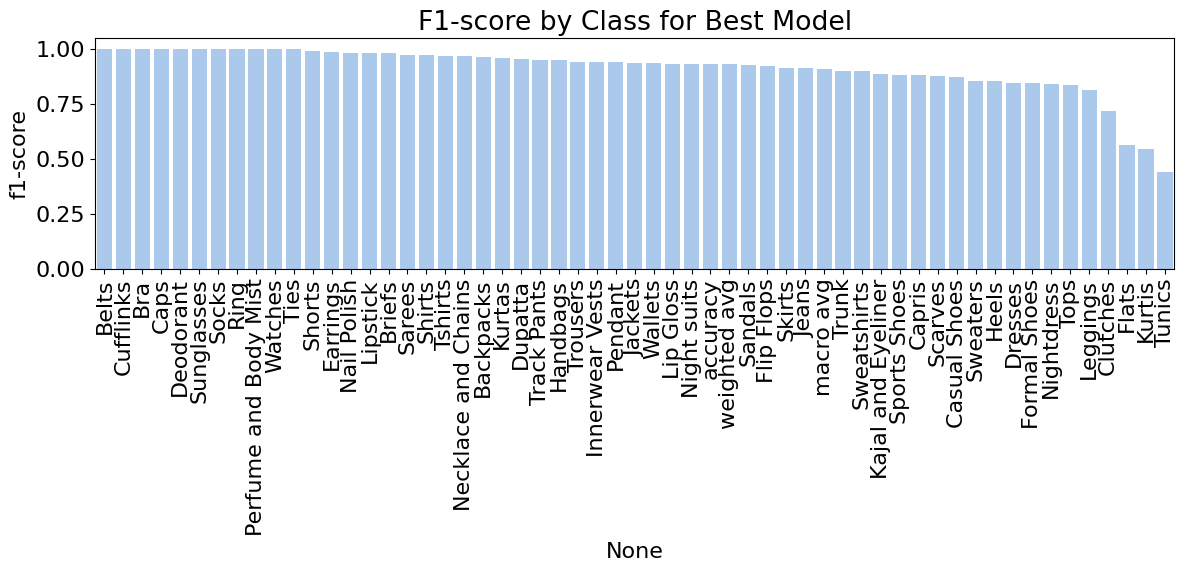


Analysis completed. All results and visualizations have been saved.


In [8]:
# Evaluation
test_results = {}
predicted_labels = {}
predicted_probabilities = {}

for model_name in models:
    print(f"Evaluating {model_name} model...")

    config = model_configs[model_name]
    test_dataset = create_dataset(
        test_df, batch_size, config["target_size"], config["preprocess_input"]
    )

    # Load the best model
    model = tf.keras.models.load_model(f"models/best_model_{model_name}.keras")
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
    test_results[model_name] = {'loss': test_loss, 'accuracy': test_accuracy}

    predictions = model.predict(test_dataset)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels[model_name] = predicted_classes
    predicted_probabilities[model_name] = predictions

    print(f"{model_name} Test Loss: {test_loss:.4f}")
    print(f"{model_name} Test Accuracy: {test_accuracy * 100:.2f}%")

# True labels
true_labels = np.argmax(pd.get_dummies(test_df["articleType"]).values, axis=1)

# Print classification report for each model
for model_name in models:
    print(f"Classification Report for {model_name}:")
    print(classification_report(true_labels, predicted_labels[model_name], target_names=class_labels))

# Plot confusion matrix for each model
for model_name in models:
    cm = confusion_matrix(true_labels, predicted_labels[model_name])
    plt.figure(figsize=(30, 25))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'artifacts/confusion_matrix_{model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Compare model performance
print("Model Performance Comparison:")
for model_name, result in test_results.items():
    print(f"{model_name}: Test Loss = {result['loss']:.4f}, Test Accuracy = {result['accuracy'] * 100:.2f}%")

# Plot Precision-Recall curve and calculate AUPRC for each model
macro_auprcs = {}
for model_name in models:
    macro_auprcs[model_name] = plot_macro_average_prc_curve(true_labels, predicted_probabilities[model_name], class_labels, model_name)

# Print macro-average AUPRC scores for all models
print("\nMacro-Average AUPRC Scores:")
for model_name, auprc_score in macro_auprcs.items():
    print(f"{model_name}: {auprc_score:.4f}")

# Plot training history for all models
for model_name, history in histories.items():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.savefig(f'artifacts/training_history_{model_name}.png')
    plt.show()
    plt.close()

print("Evaluation completed for all models.")
print(f"Class labels: {class_labels}")

# Identify the best performing model
best_model = max(test_results, key=lambda x: test_results[x]['accuracy'])
print(f"\nBest performing model: {best_model}")
print(f"Best model accuracy: {test_results[best_model]['accuracy'] * 100:.2f}%")

# Additional analysis for the best model
best_model_predictions = predicted_labels[best_model]

# Top misclassified classes
misclassified = true_labels != best_model_predictions
misclassified_df = pd.DataFrame({
    'True': [class_labels[i] for i in true_labels[misclassified]],
    'Predicted': [class_labels[i] for i in best_model_predictions[misclassified]]
})
top_misclassified = misclassified_df.groupby(['True', 'Predicted']).size().sort_values(ascending=False).head(10)

print("\nTop 10 misclassified pairs:")
print(top_misclassified)

# Save top misclassified pairs
top_misclassified.to_csv('artifacts/top_misclassified.csv')

# Class-wise accuracy
class_accuracy = classification_report(true_labels, best_model_predictions, target_names=class_labels, output_dict=True)
class_accuracy_df = pd.DataFrame(class_accuracy).transpose()
class_accuracy_df = class_accuracy_df.sort_values('f1-score', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=class_accuracy_df.index, y=class_accuracy_df['f1-score'])
plt.title('F1-score by Class for Best Model')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('artifacts/f1_score_by_class.png')
plt.show()
plt.close()

print("\nAnalysis completed. All results and visualizations have been saved.")